In [69]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import NearMiss
from sklearn.manifold import TSNE
from time import time
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.random_projection import GaussianRandomProjection
from scipy.stats import kurtosis
from sklearn.decomposition import FastICA
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc, silhouette_score, mean_squared_error, f1_score


np.random.seed(42)

def plot_learning_curve(model, chart_title, features, targets, score_limits=None, cross_val_method=None, n_jobs=None, data_points=np.linspace(0.1, 1.0, 5)):
 
    plt.figure(figsize=(8, 6))
    plt.title(chart_title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    if score_limits is not None:
        plt.ylim(score_limits)
    
    sample_sizes, training_scores, test_scores = learning_curve(
        model, features, targets, cv=cross_val_method, n_jobs=n_jobs, train_sizes=data_points
    )

    mean_training_scores = np.mean(training_scores, axis=1)
    std_training_scores = np.std(training_scores, axis=1)
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    

    plt.grid(True, linestyle='--')
    plt.fill_between(sample_sizes, mean_training_scores - std_training_scores, mean_training_scores + std_training_scores, alpha=0.1, color="#FFA07A")
    plt.fill_between(sample_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.1, color="#20B2AA")
    plt.plot(sample_sizes, mean_training_scores, 'o-', color="#FF6347", label="Training Accuracy")
    plt.plot(sample_sizes, mean_test_scores, 'o-', color="#3CB371", label="test Accuracy")
    
    plt.legend(loc="lower right")
    plt.show()
    return plt

def plot_validation_curve(data_features, data_target, classifier, model_type): 
    if model_type == 'svm':
        hyperparameter_values = [0.01, 0.1, 1.0, 10.0, 70,100.0]
        hyperparameter = 'C'
    elif model_type == 'decision tree':
        hyperparameter_values = np.arange(1, 20)
        hyperparameter = 'max_depth'
    elif model_type == 'knn':
        hyperparameter_values = np.arange(1, 20)
        hyperparameter = 'n_neighbors'
    elif model_type == 'neural network':
        hyperparameter_values = [1e-03, 1e-02, 1e-01, 1]
        hyperparameter = 'alpha'
    elif model_type == 'boosted decision tree':
        hyperparameter_values = np.arange(10, 200,15)
        hyperparameter = 'n_estimators'

    train_scores, val_scores = validation_curve(
        classifier, data_features, data_target, 
        param_name=hyperparameter, param_range=hyperparameter_values, 
        cv=5, scoring="accuracy", n_jobs=1
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    mean_val_scores = np.mean(val_scores, axis=1)
    std_val_scores = np.std(val_scores, axis=1)

    plt.title("Breast Validation Curve for " + model_type)
    plt.xlabel(hyperparameter)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    plt.grid(True)
    line_width = 2
    plt.plot(hyperparameter_values, mean_train_scores, 'o-', color="red", lw=line_width, label="Training Accuracy")
    plt.fill_between(hyperparameter_values, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, color="red", alpha=0.2, lw=line_width)
    plt.plot(hyperparameter_values, mean_val_scores, 's-', color="blue", lw=line_width, label="Cross-validation Accuracy")
    plt.fill_between(hyperparameter_values, mean_val_scores - std_val_scores, mean_val_scores + std_val_scores, color="blue", alpha=0.2, lw=line_width)
    plt.legend(loc="lower right")
    plt.show()

def compute_and_plot_accuracy(y_true, cluster_labels_list):
    accuracy_scores = []
    for cluster_labels in cluster_labels_list:
        predictions = np.empty_like(y_true)

        for cluster_label in np.unique(cluster_labels):
            match = (cluster_labels == cluster_label)
            most_common_label = Counter(y_true[match]).most_common(1)[0][0]
            predictions[match] = most_common_label
        accuracy = accuracy_score(y_true, predictions)
        accuracy_scores.append(accuracy)
    
    return accuracy_scores


In [49]:
n_cpu = os.cpu_count()
n_thread = n_cpu*2

In [50]:
df = pd.read_csv("./data/Breast_Cancer.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [51]:
df['Status'].value_counts()

Alive    3408
Dead      616
Name: Status, dtype: int64

In [52]:
X_num = df[['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive']]
X_cat = df.drop(['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Status'], axis=1)
y = df['Status']

In [53]:
le = LabelEncoder()
y = le.fit_transform(y)
for col in X_cat.columns:
  X_cat[col] = le.fit_transform(X_cat[col])

In [54]:
X = pd.concat([X_num, X_cat], axis=1)
X.head()

Age  Tumor Size  Regional Node Examined  Reginol Node Positive  Race  \
0   68           4                      24                      1     2   
1   50          35                      14                      5     2   
2   58          63                      14                      7     2   
3   58          18                       2                      1     2   
4   47          41                       3                      1     2   

   Marital Status  T Stage   N Stage  6th Stage  differentiate  Grade  \
0               1         0        0          0              1      3   
1               1         1        1          2              0      2   
2               0         2        2          4              0      2   
3               1         0        0          0              1      3   
4               1         1        0          1              1      3   

   A Stage  Estrogen Status  Progesterone Status  Survival Months  
0        1                1                    1               59  
1        1                1                    1               61  
2        1                1                    1               74  
3        1                1                    1               83  
4        1                1                    1               49

In [55]:
nm=NearMiss()
X_scaled, y_scaled = nm.fit_resample(X, y)
# X_scaled, y_scaled = nm.fit_resample(X_scaled, y_scaled)
X_scaled.count()

Age                       1232
Tumor Size                1232
Regional Node Examined    1232
Reginol Node Positive     1232
Race                      1232
Marital Status            1232
T Stage                   1232
N Stage                   1232
6th Stage                 1232
differentiate             1232
Grade                     1232
A Stage                   1232
Estrogen Status           1232
Progesterone Status       1232
Survival Months           1232
dtype: int64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=1)

In [57]:
X_train.shape, y_test.shape

((924, 15), (308,))

## K Means

In [60]:
import time
def kmeans_func(X_train, X_test, y_test):
    k_list = [2,3,4,5,6,7,8,9,10,13,15,20,25,30,35,40,45,50,75,100]
    kmeans_result_1 = {
    "SSE": [],
    "silhouette": [],
    "time": [],
    
    }
    # plot_k_values = [2, 3, 4, 5]  # Example subset of K values you want to plot

    # plt.figure(figsize=(10, len(plot_k_values) * 3))  # Adjust the figure size as needed

    # for i, k in enumerate(k_list):
    #     start_time = time.time()
    #     km_model = KMeans(n_clusters=k, random_state=42)
    #     km_model.fit(X_train)
    #     km_pred = km_model.predict(X_test)
        
    #     # Store results
    #     kmeans_result_1['cluster_labels'].append(km_pred)
    #     elapsed_time = time.time() - start_time
    #     kmeans_result_1["time"].append(elapsed_time)
    #     kmeans_result_1["SSE"].append(km_model.inertia_)
    #     kmeans_result_1["silhouette"].append(silhouette_score(X_test, km_pred))

    #     # Plot clustering results for selected K values
    #     if k in plot_k_values:
    #         plt_idx = plot_k_values.index(k) + 1
    #         plt.subplot(len(plot_k_values), 1, plt_idx)
    #         plt.scatter(X_test.iloc[:, 0] if isinstance(X_test, pd.DataFrame) else X_test[:, 0], 
    #         X_test.iloc[:, 1] if isinstance(X_test, pd.DataFrame) else X_test[:, 1], 
    #         c=km_pred, cmap='viridis', marker='.', s=30, alpha=0.7)
    #         plt.title(f'Cluster Plot for K={k}')
    #         plt.xlabel('Feature 1')
    #         plt.ylabel('Feature 2')

    # plt.tight_layout()
    # plt.show()
    for k in k_list:
        start_time = time.time()
        km_model = KMeans(n_clusters=k, random_state=42)
        km_model.fit(X_train)
        km_pred = km_model.predict(X_test)
        kmeans_result_1['cluster_labels'].append(km_pred)
        end_time = time.time()
        
        elapsed_time = end_time-start_time
        sse = km_model.inertia_
        silhouette_avg = silhouette_score(X_test, km_pred)

        kmeans_result_1["time"].append(elapsed_time)
        kmeans_result_1["SSE"].append(sse)
        kmeans_result_1["silhouette"].append(silhouette_avg)


    # Plot for SSE
    plt.subplot(2, 2, 1)  # 1 row, 3 columns, 1st subplot
    plt.plot(k_list, kmeans_result_1['SSE'], marker='o')
    plt.title('Sum of Squared Errors (SSE) vs. K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('SSE')

    # Plot for Silhouette Score
    plt.subplot(2, 2, 2)  # 1 row, 3 columns, 2nd subplot
    plt.plot(k_list, kmeans_result_1['silhouette'], marker='o', color='green')
    plt.title('Silhouette Score vs. K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')

    # Plot for Time
    plt.subplot(2, 2, 3)  # 1 row, 3 columns, 3rd subplot
    plt.plot(k_list, kmeans_result_1['time'], marker='o', color='red')
    plt.title('Time Taken vs. K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Time (seconds)')

    plt.subplot(2, 2, 4)
    plt.plot(k_list, acc, marker='o', color='orange')
    plt.title('accuracy vs. K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('accuracy')


    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/d

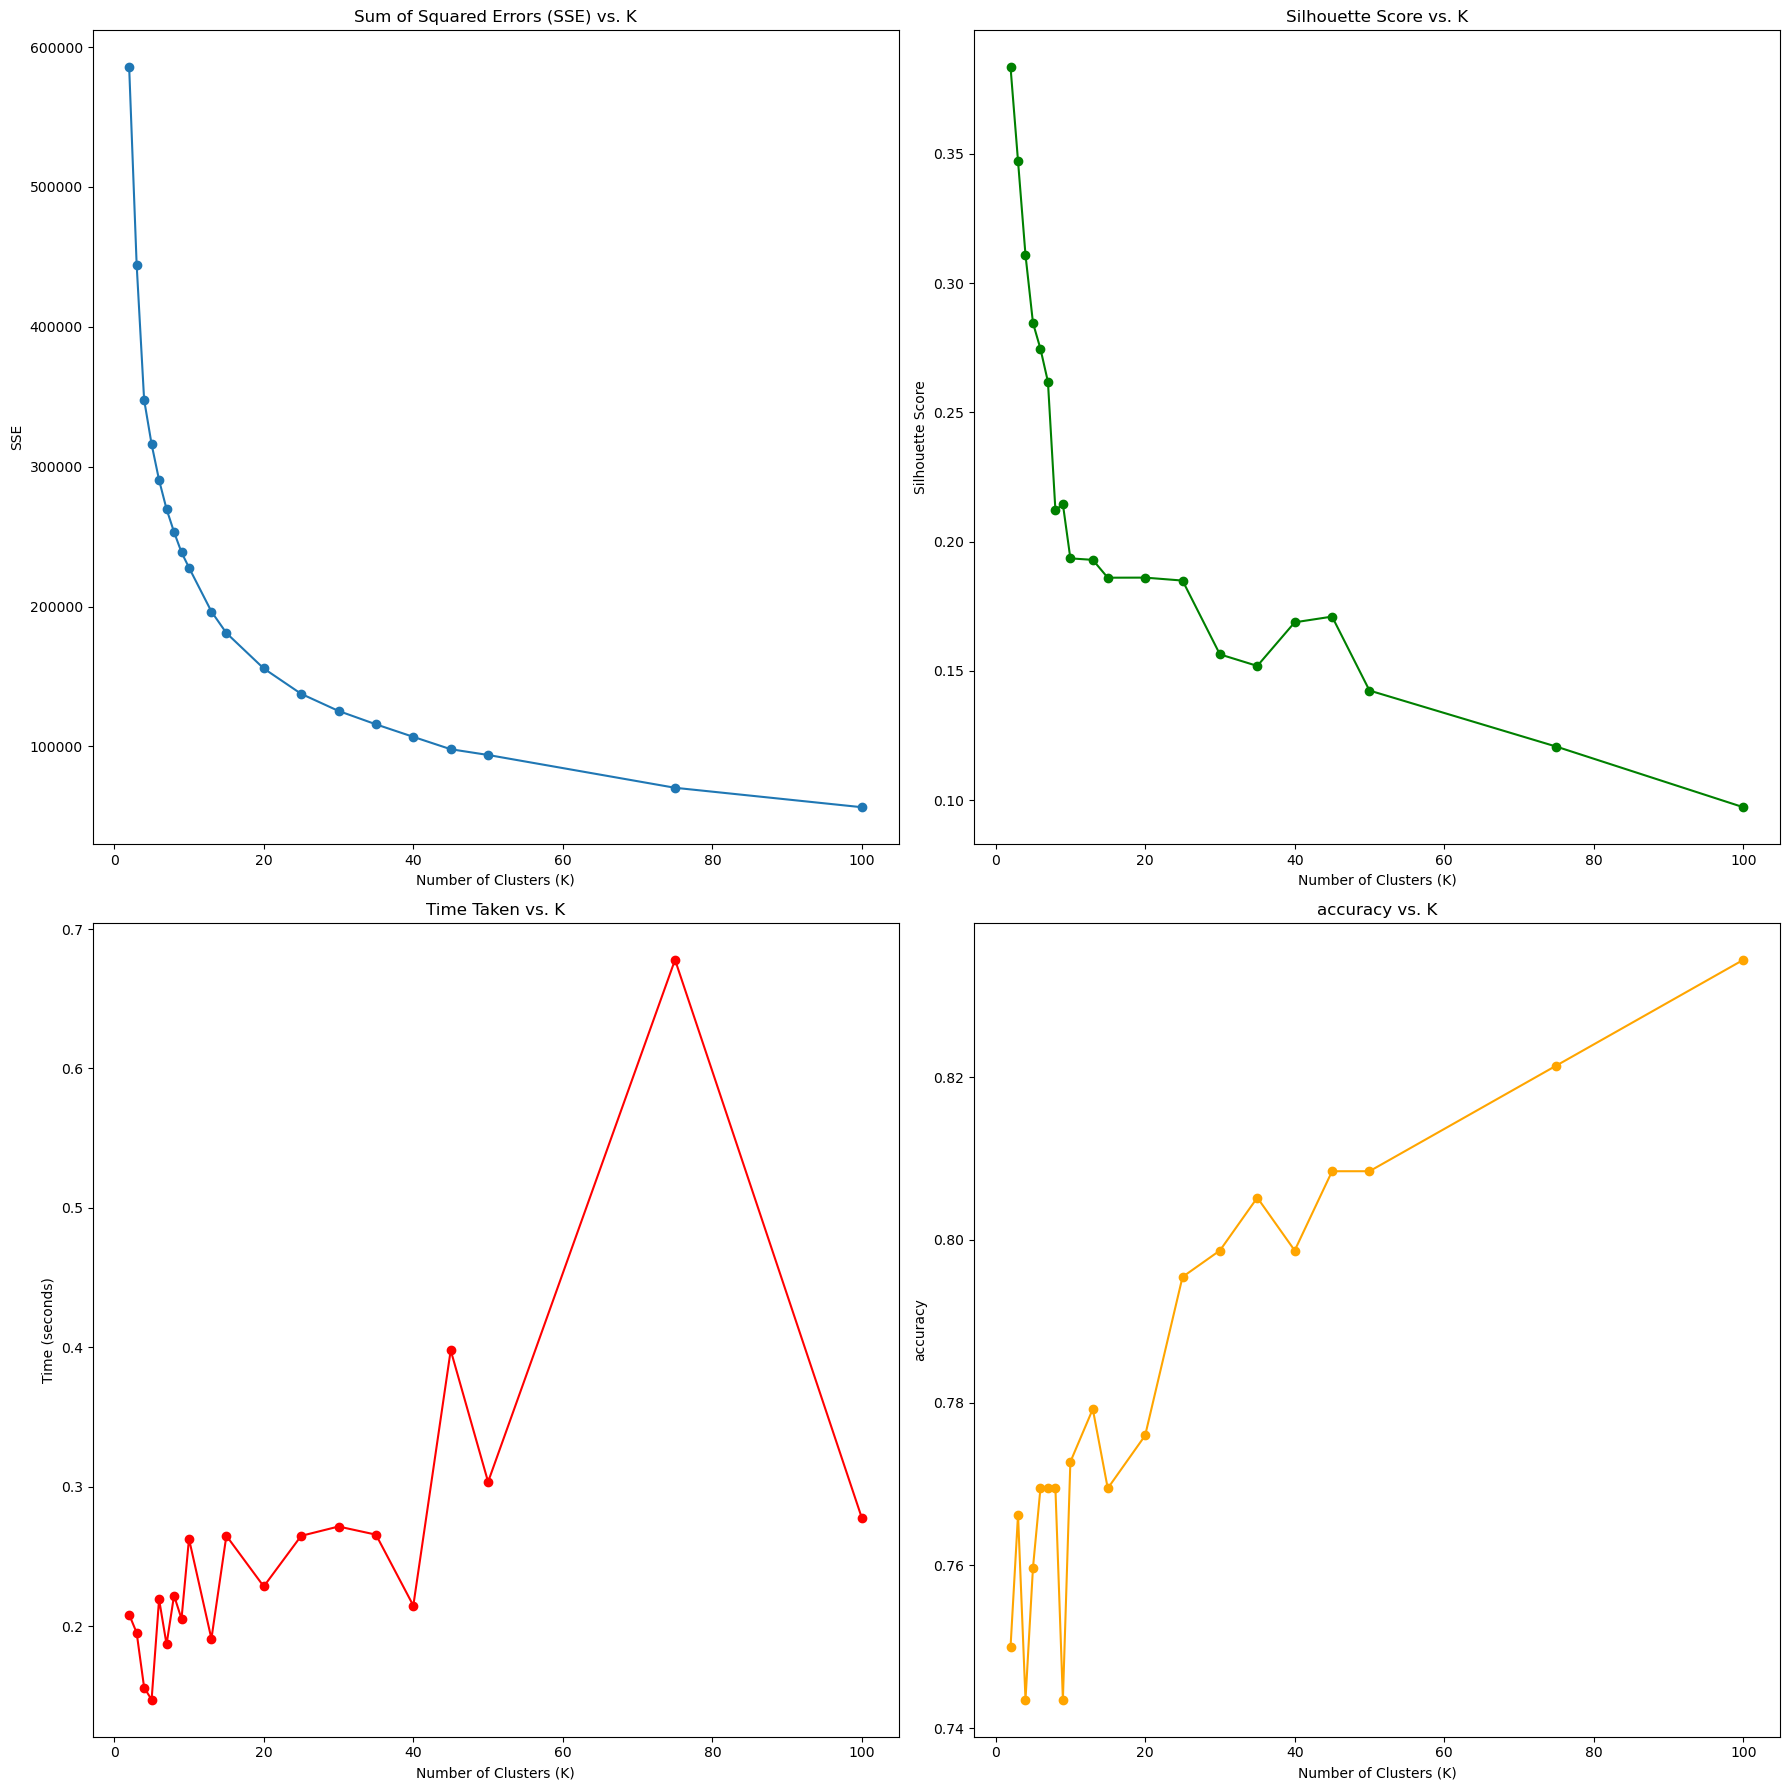

In [61]:
kmeans_func(X_train, X_test, y_test)

In [64]:
km_model = KMeans(n_clusters=2, random_state=42)
km_model.fit(X_train)
km_pred = km_model.predict(X_test)
print(classification_report(y_test, km_pred))

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.68      0.97      0.80       159
           1       0.94      0.52      0.67       149

    accuracy                           0.75       308
   macro avg       0.81      0.74      0.73       308
weighted avg       0.81      0.75      0.74       308



Expectation Maximization 

In [65]:
def gmm_func(X_train, X_test, y_test):
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    gmm_result = {
        "silhouette": [],
        "time": [],
        "cluster_labels": []
    }

    for k in k_list:
        start_time = time.time()
        gmm_model = GaussianMixture(n_components=k, random_state=42)
        gmm_model.fit(X_train)
        gmm_pred = gmm_model.predict(X_test)
        gmm_result['cluster_labels'].append(gmm_pred)
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        silhouette_avg = silhouette_score(X_test, gmm_pred)
        
        gmm_result["time"].append(elapsed_time)
        gmm_result["silhouette"].append(silhouette_avg)

    acc = compute_and_plot_accuracy(y_test, gmm_result["cluster_labels"])  # Assumes this function is defined elsewhere
    
    plt.figure(figsize=(18, 18))
    
    # Plot for Silhouette Score
    plt.subplot(2, 2, 1)
    plt.plot(k_list, gmm_result['silhouette'], marker='o', color='green')
    plt.title('Silhouette Score vs. K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    
    # Plot for Time
    plt.subplot(2, 2, 2)
    plt.plot(k_list, gmm_result['time'], marker='o', color='red')
    plt.title('Time Taken vs. K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Time (seconds)')

    plt.subplot(2, 2, 3)
    plt.plot(k_list, acc, marker='o', color='orange')  # Plot accuracy if applicable
    plt.title('Accuracy vs. K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

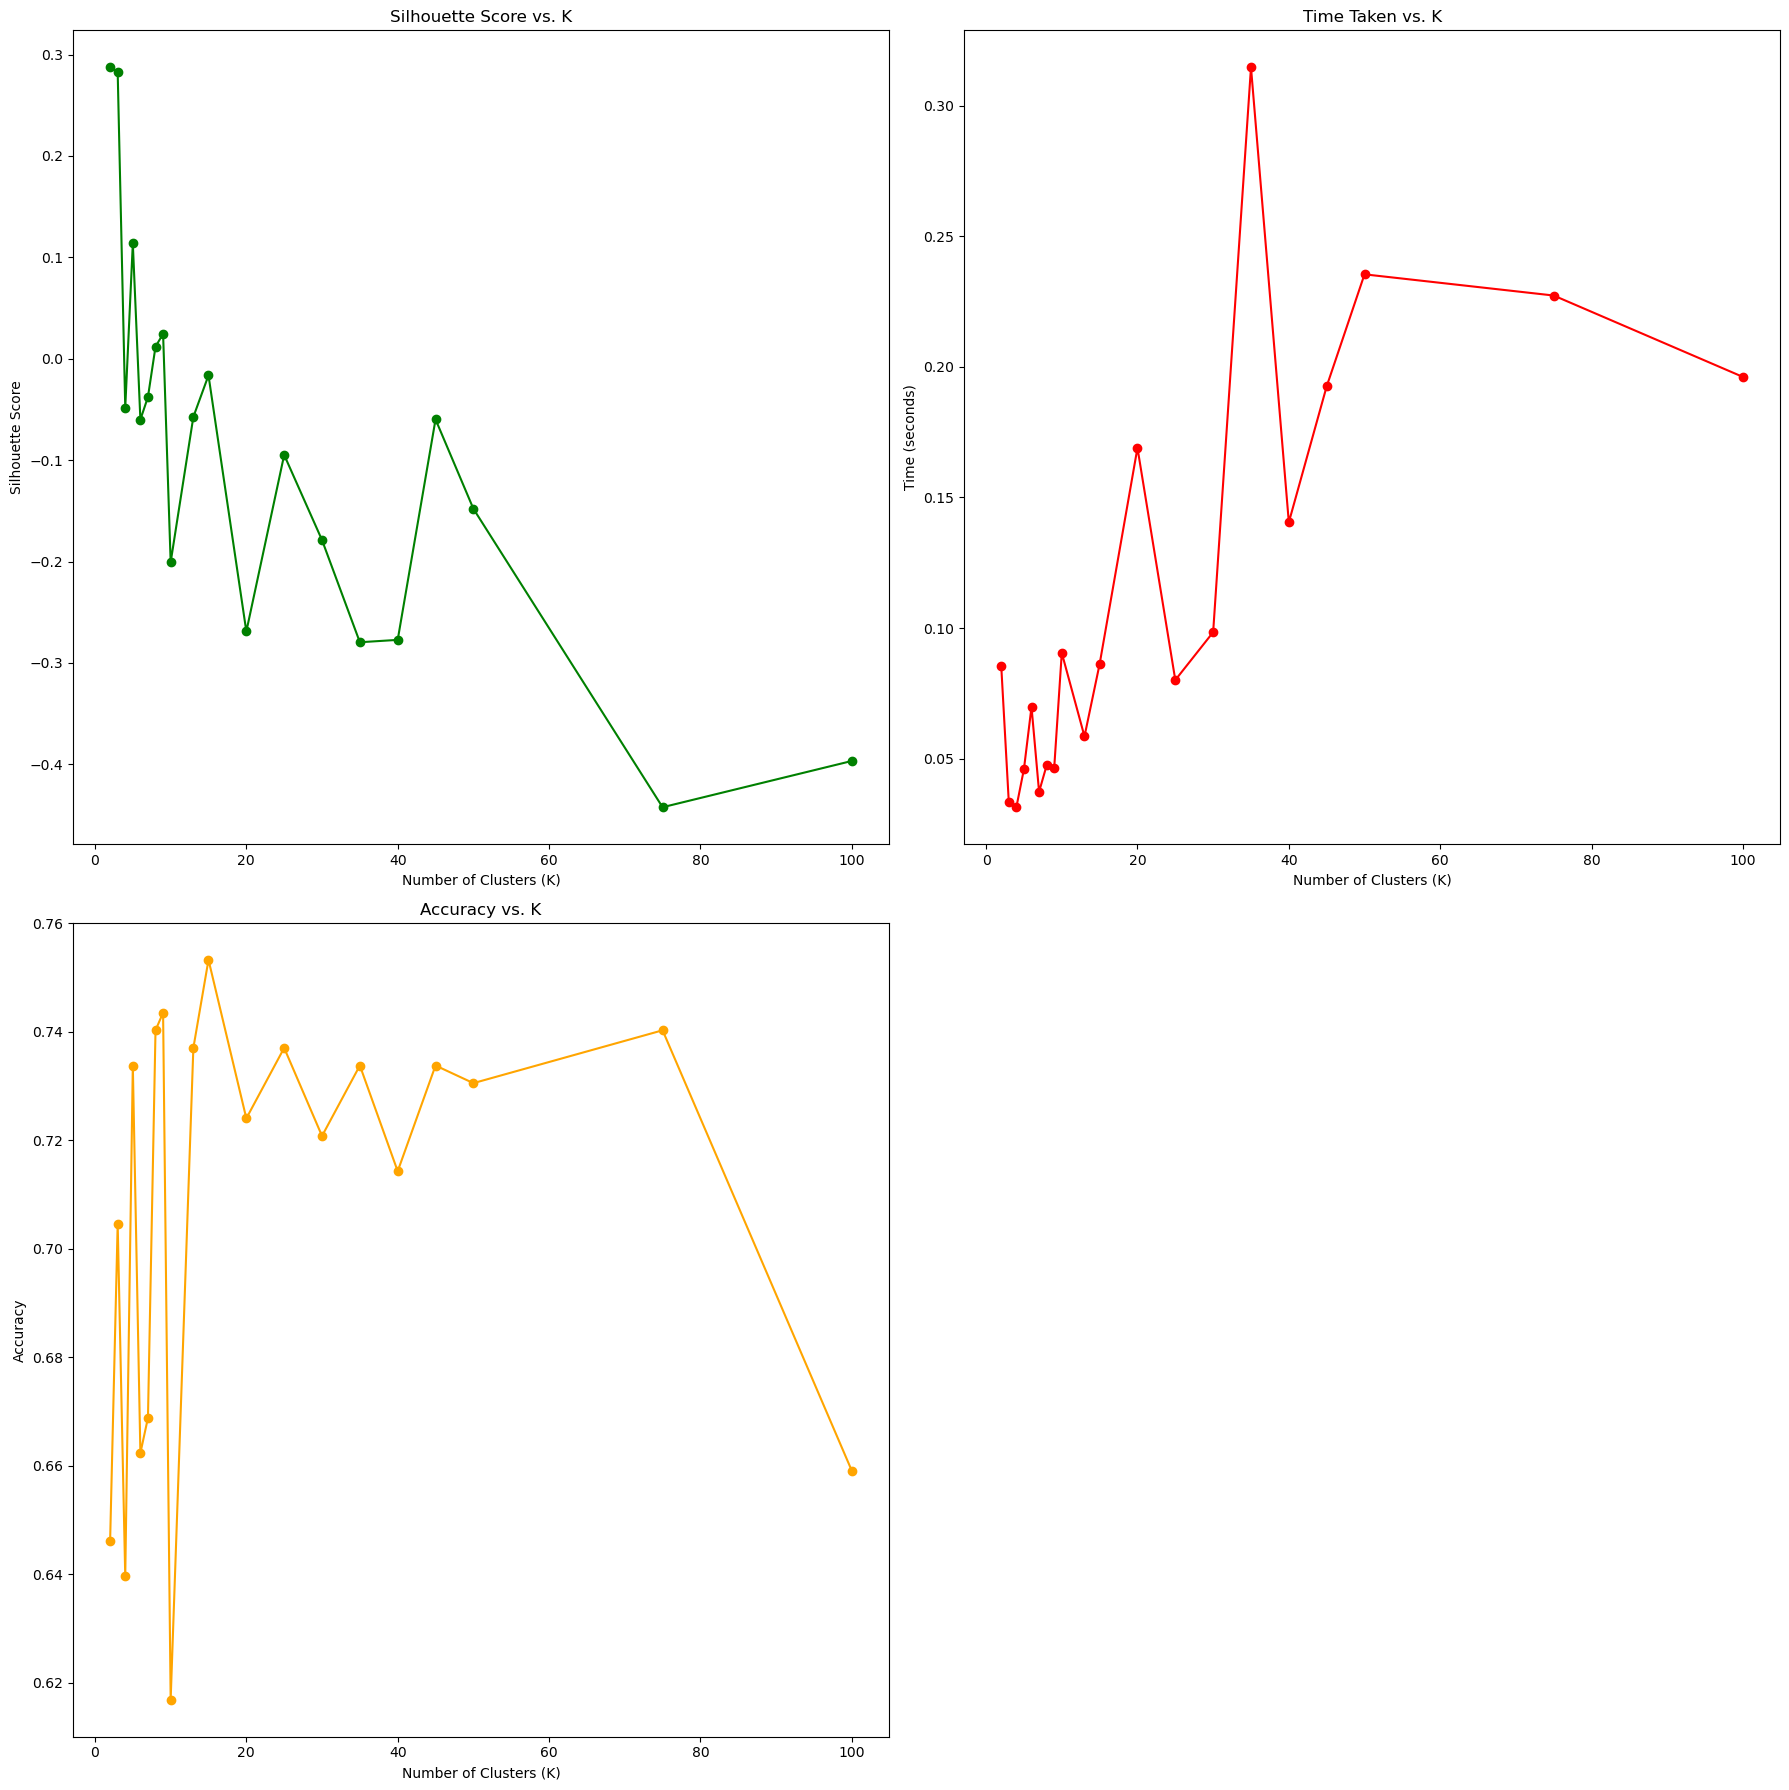

In [66]:
gmm_func(X_train, X_test, y_test)

In [67]:
gmm_model = GaussianMixture(n_components=2, random_state=42)
gmm_model.fit(X_train)
gmm_pred = gmm_model.predict(X_test)
print(classification_report(y_test, gmm_pred))

              precision    recall  f1-score   support

           0       0.60      0.98      0.74       159
           1       0.93      0.29      0.44       149

    accuracy                           0.65       308
   macro avg       0.77      0.63      0.59       308
weighted avg       0.76      0.65      0.60       308



## PCA

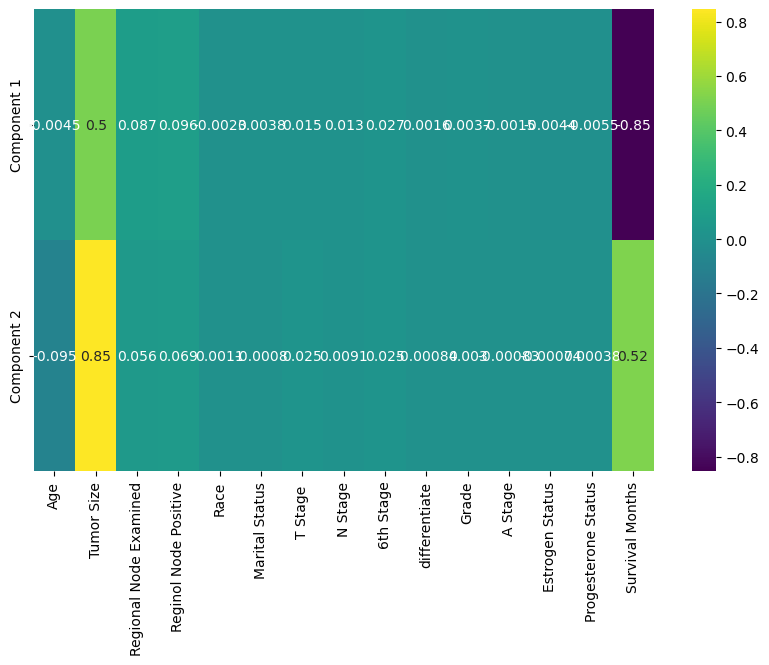

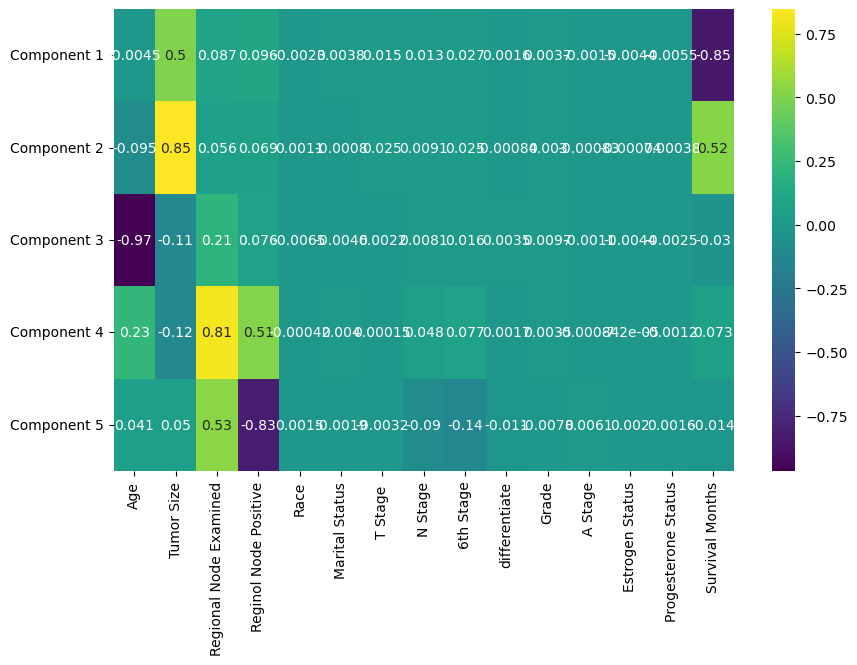

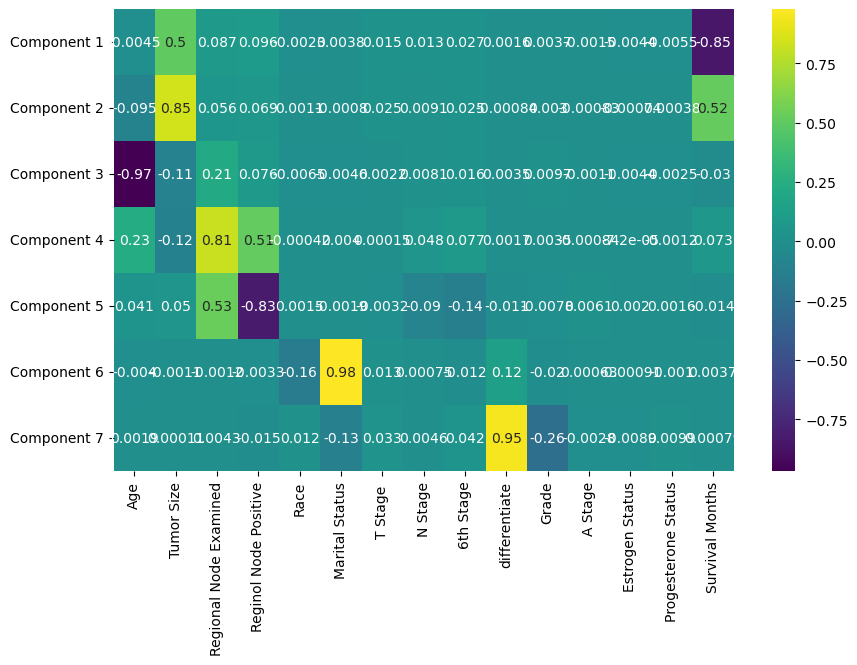

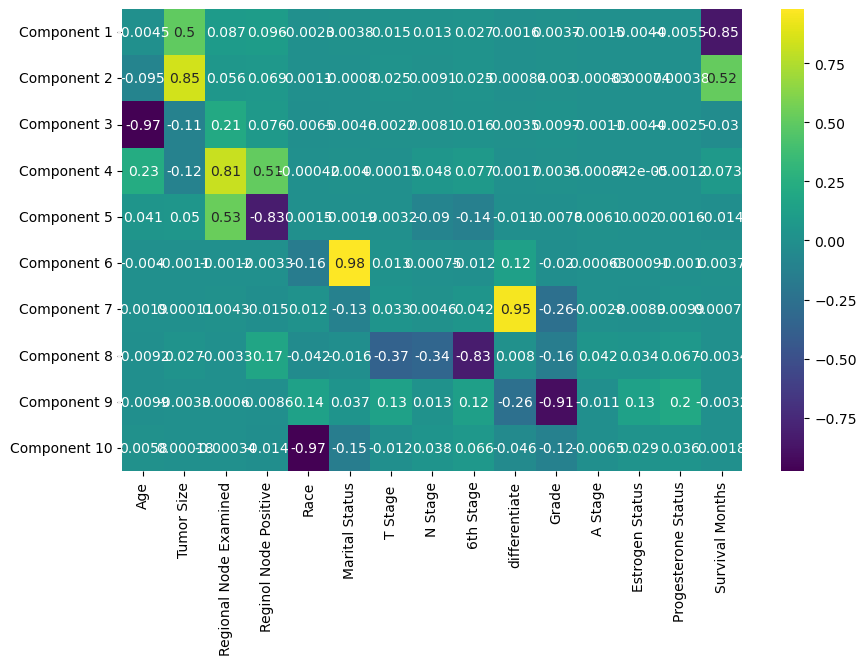

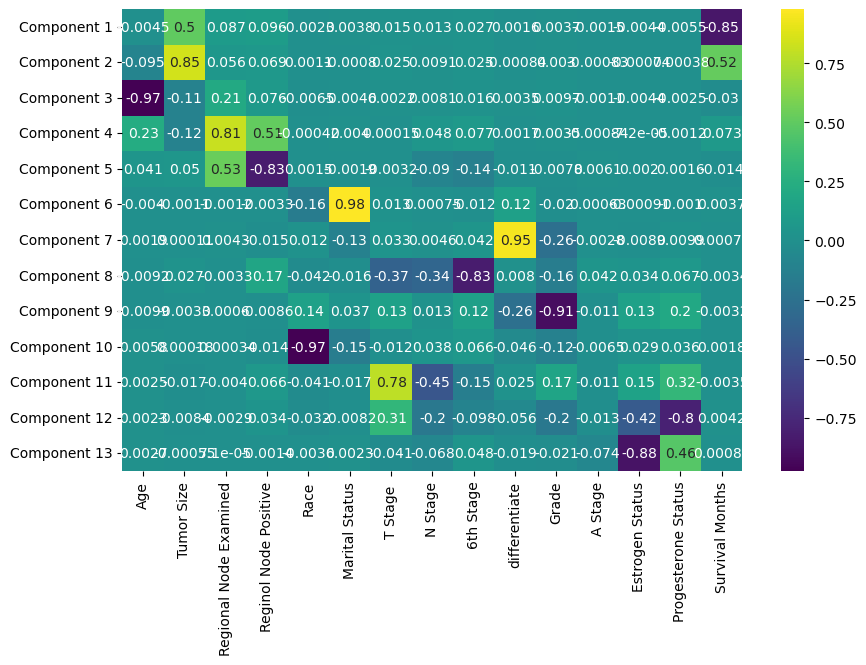

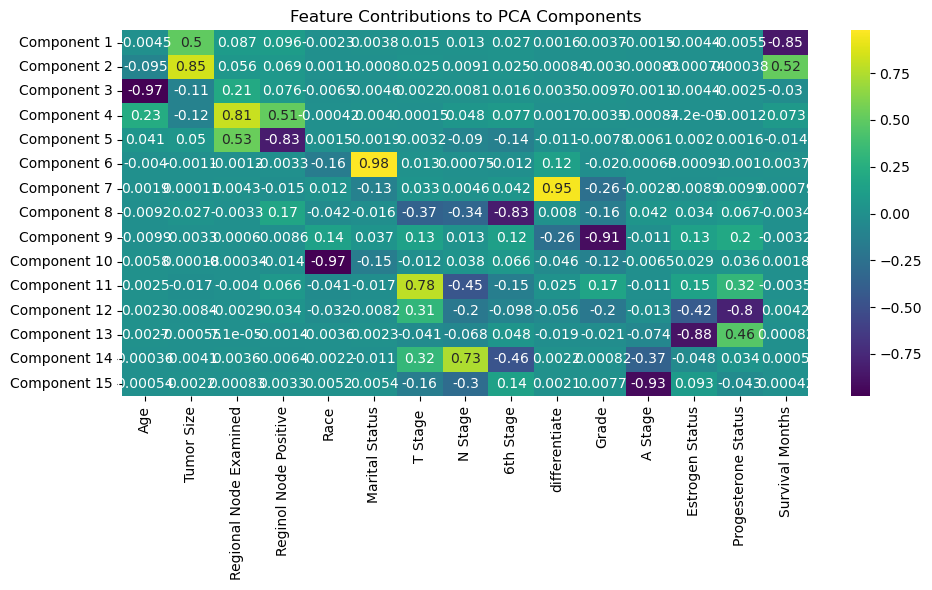

In [71]:
pca_components = [2, 5, 7, 10, 13, 15]  # Example PCA components list
cov = []
    
for components in pca_components:
        pca = PCA(n_components=components)
        X_pca = pca.fit_transform(X_scaled)
        # cov.append(X_pca.cova)
        plt.figure(figsize=(10, 6))
        sns.heatmap(pca.components_,
            annot=True,
            cmap='viridis',
            yticklabels=[f"Component {i+1}" for i in range(X_pca.shape[1])],
            xticklabels=X_scaled.columns)
plt.title('Feature Contributions to PCA Components')
plt.tight_layout()
plt.show()

## ICA

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


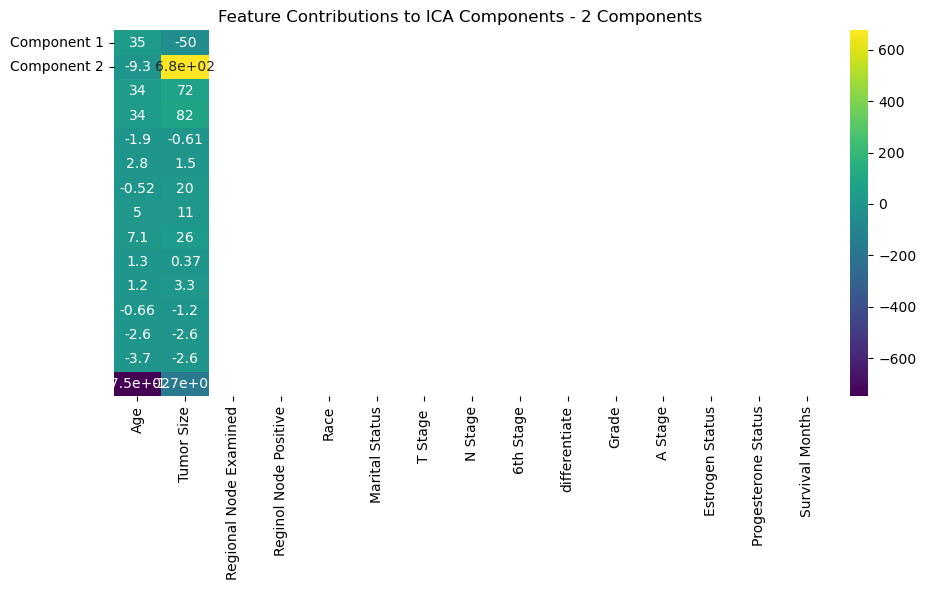

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


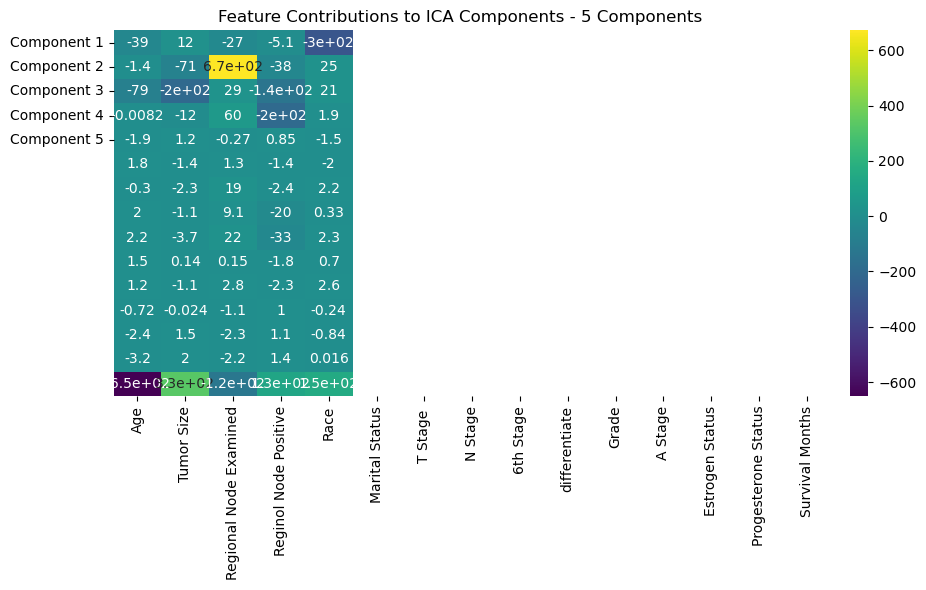

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


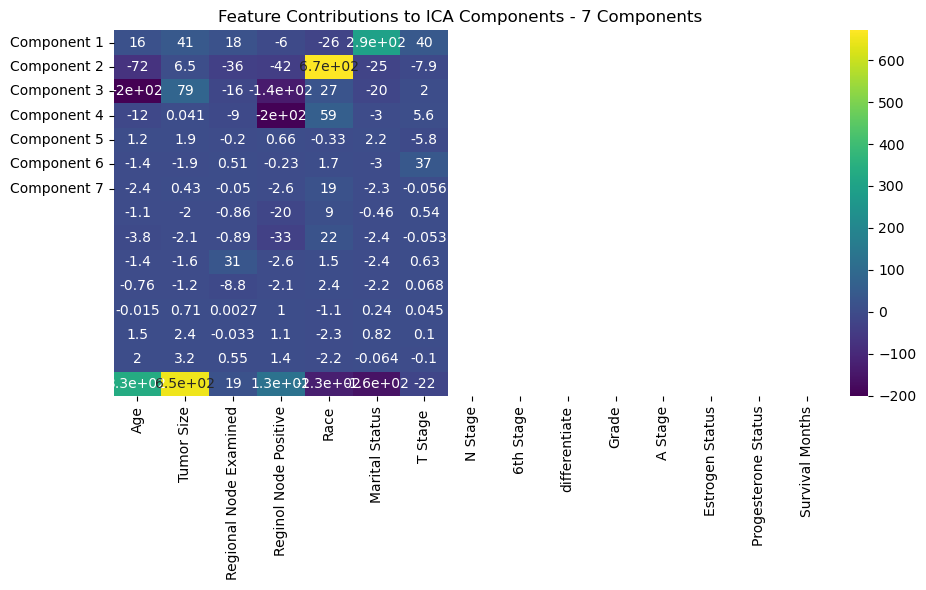

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


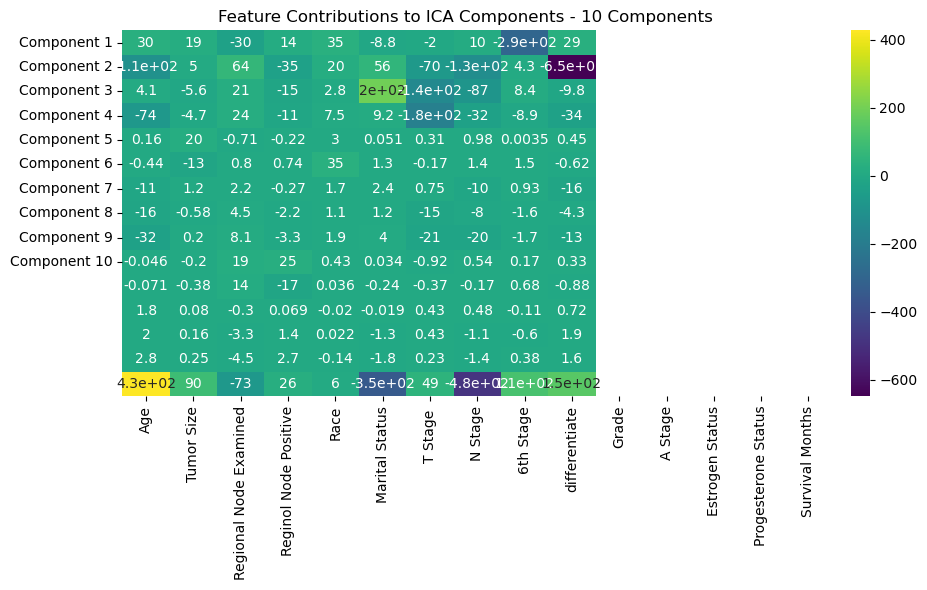

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


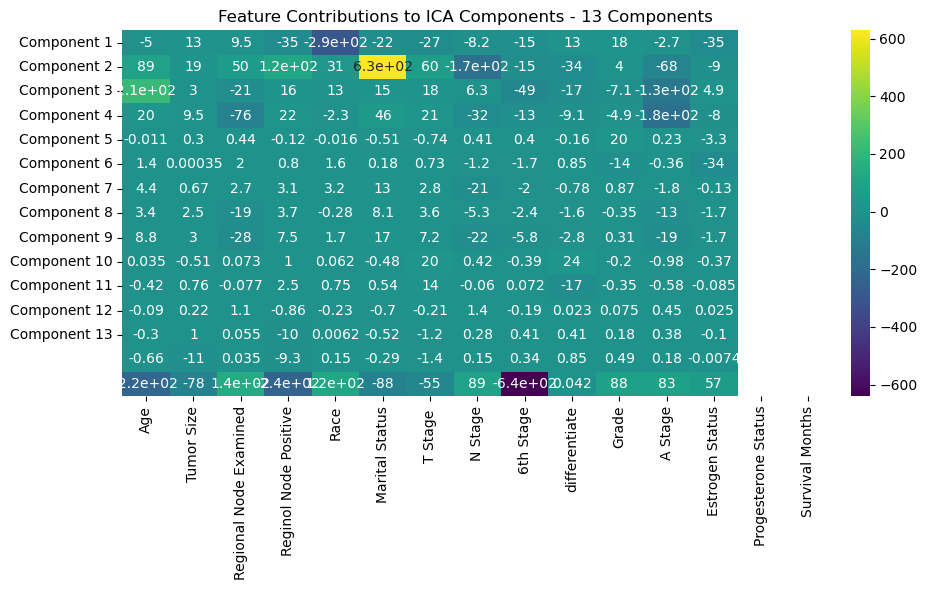

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


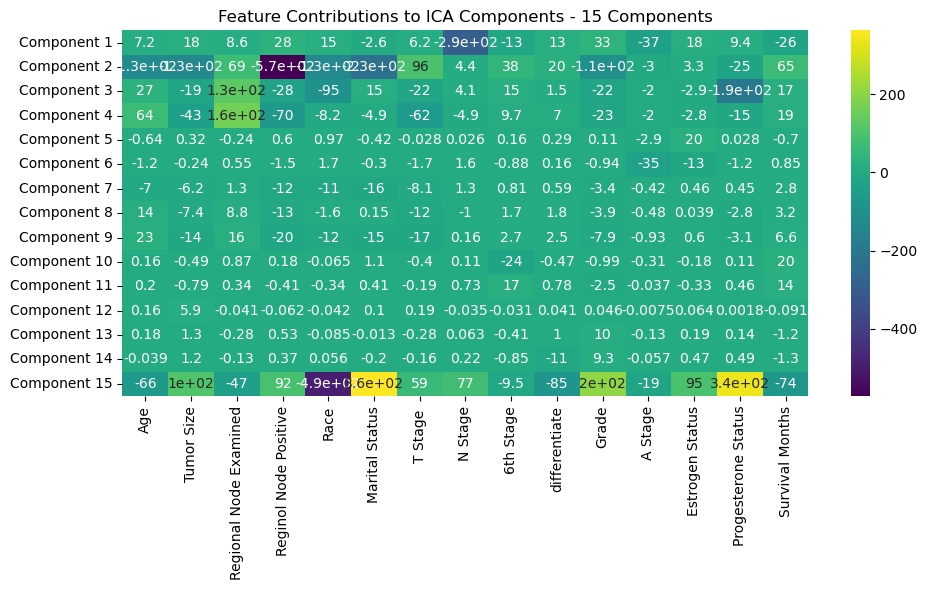

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:589: UserWarning: n_components is too large: it will be set to 15
  warnings.warn(


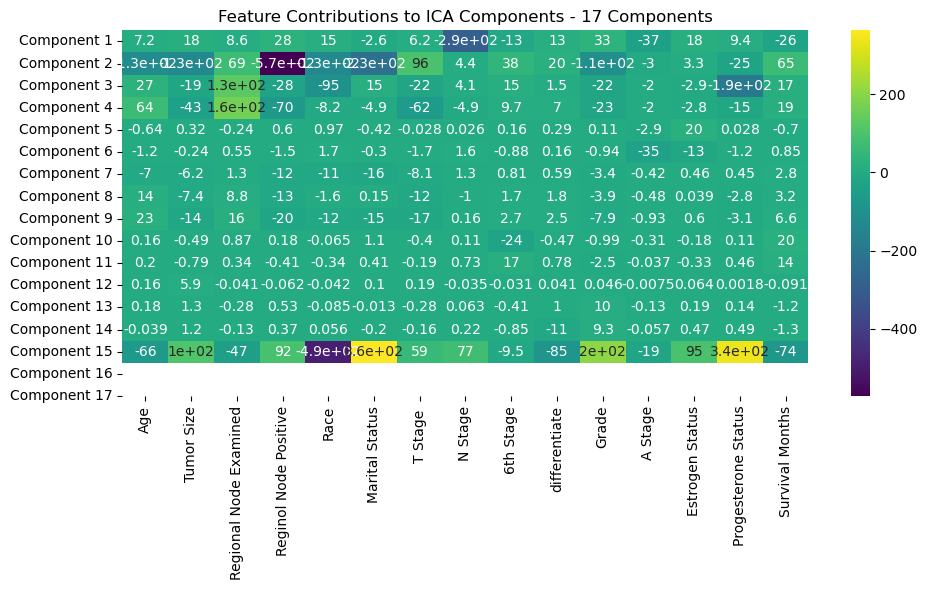

In [72]:
ica_components = [2, 5, 7, 10, 13, 15, 17]  # Example ICA components list
cov = []
    
for components in ica_components:
    ica = FastICA(n_components=components, random_state=0)
    X_ica = ica.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    # Using ica.mixing_ instead of pca.components_, as it represents the mixing matrix (approximation of the inverse of ICA unmixing matrix)
    sns.heatmap(ica.mixing_,
                annot=True,
                cmap='viridis',
                yticklabels=[f"Component {i+1}" for i in range(components)],
                xticklabels=X_scaled.columns)
    plt.title(f'Feature Contributions to ICA Components - {components} Components')
    plt.tight_layout()
    plt.show()

## RP

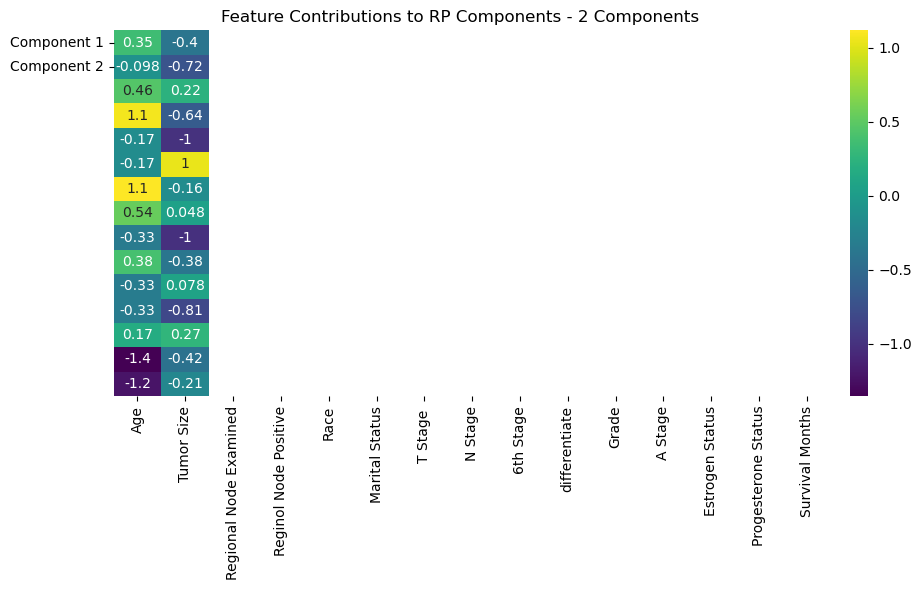

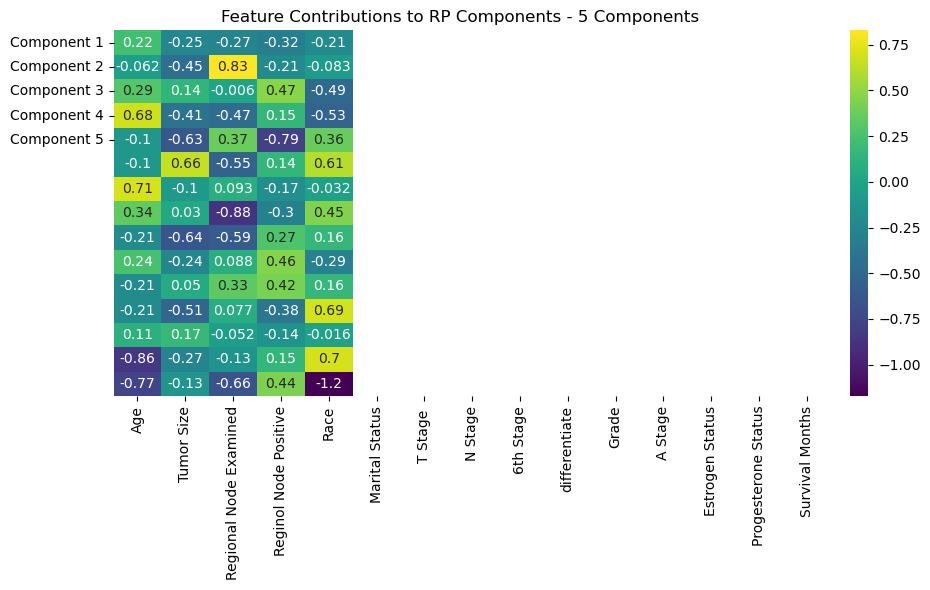

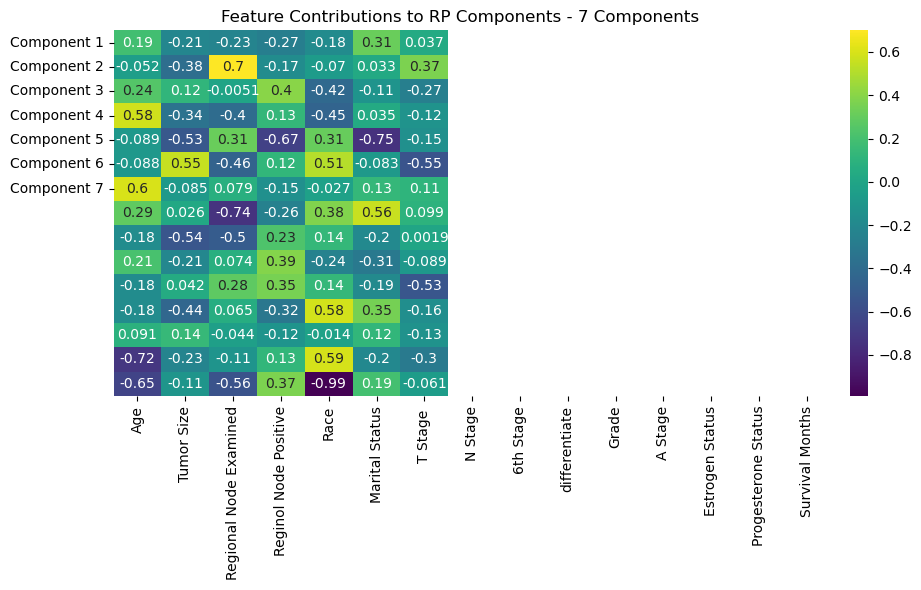

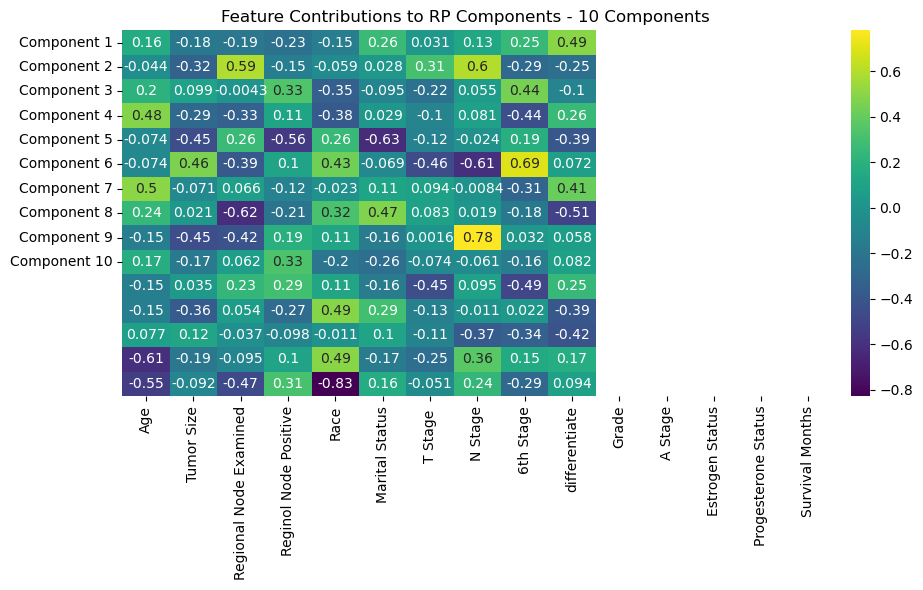

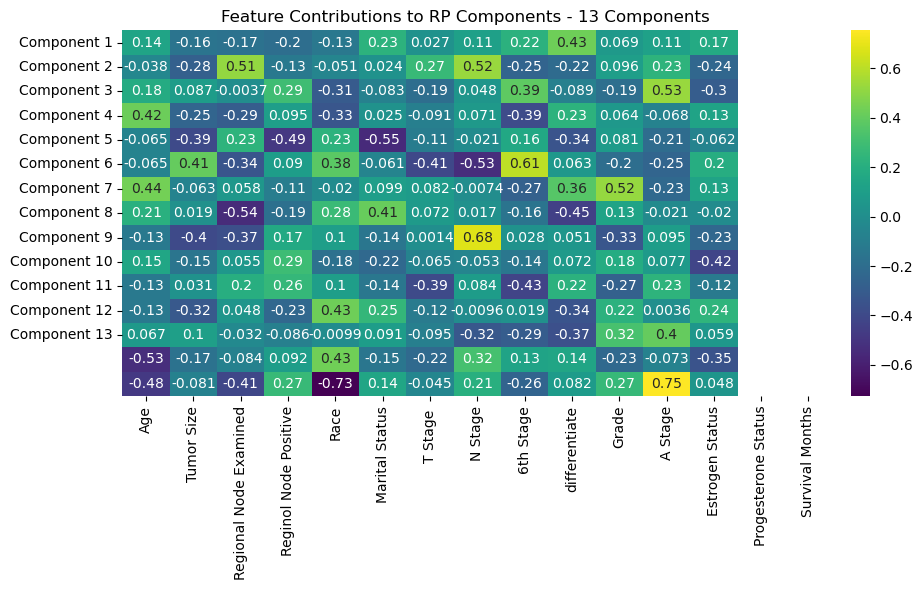

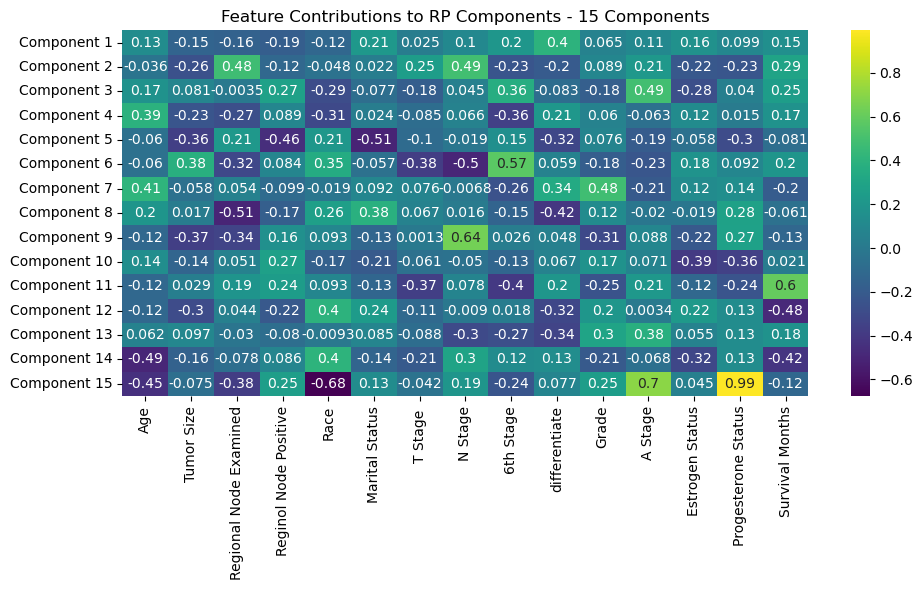

In [77]:

rp_components = [2, 5, 7, 10, 13, 15]  # Example RP components list

for components in rp_components:
    rp = GaussianRandomProjection(n_components=components, random_state=42)
    X_rp = rp.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    # Visualizing the components_ matrix. Note: Each row in components_ corresponds to a component
    sns.heatmap(np.transpose(rp.components_),
                annot=True,
                cmap='viridis',
                yticklabels=[f"Component {i+1}" for i in range(components)],
                xticklabels=X_scaled.columns)  # Assuming feature names are known and correspond to columns in X_scaled
    plt.title(f'Feature Contributions to RP Components - {components} Components')
    plt.tight_layout()
    plt.show()

## TSNE

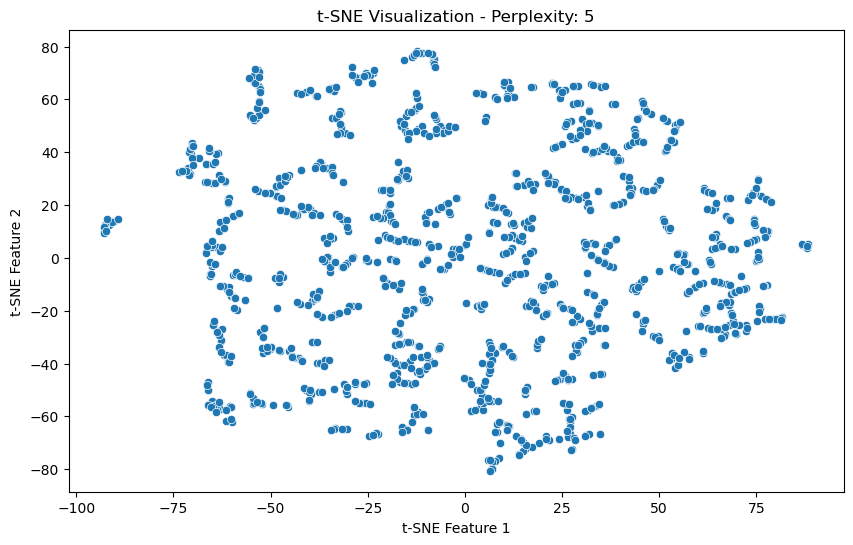

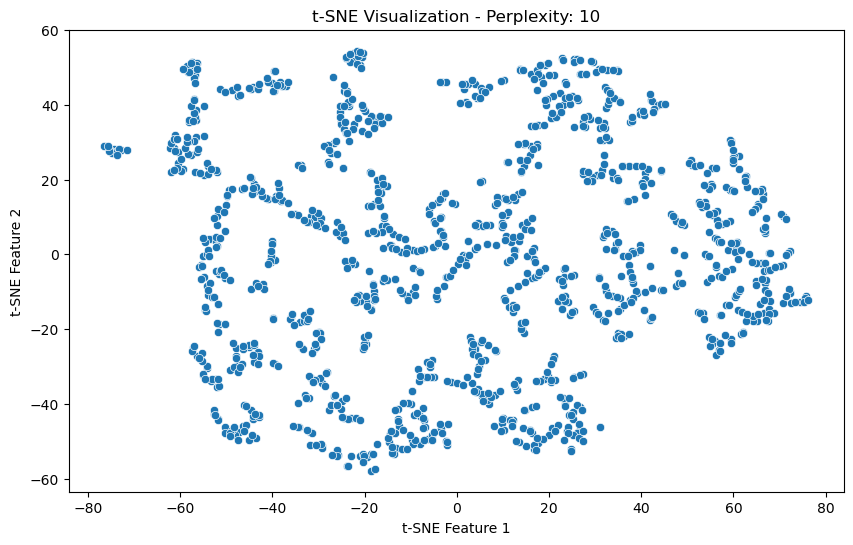

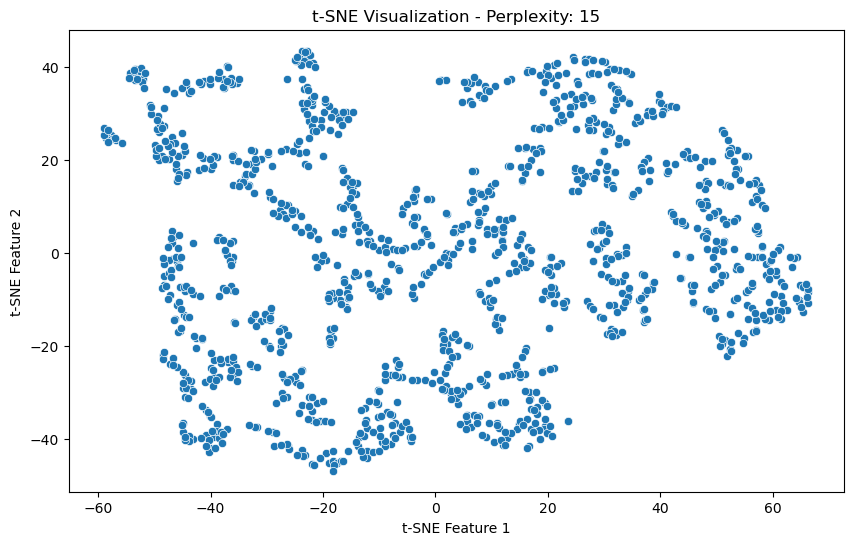

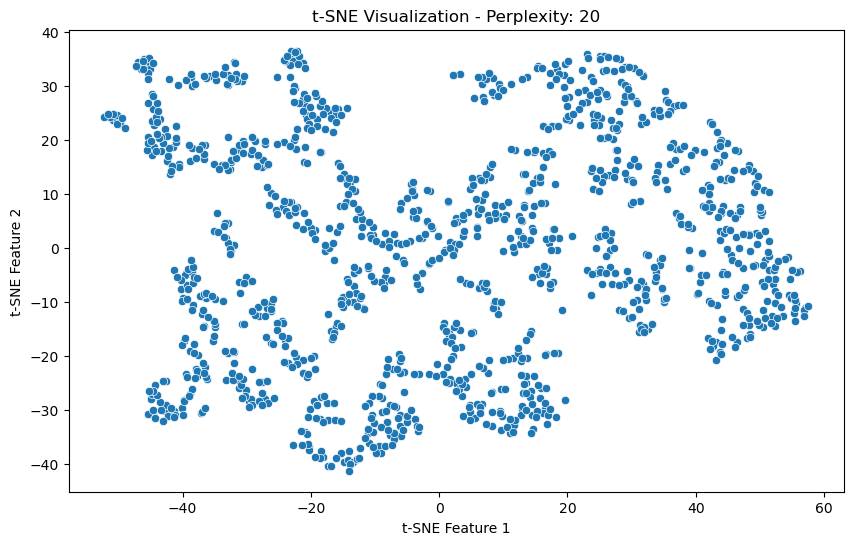

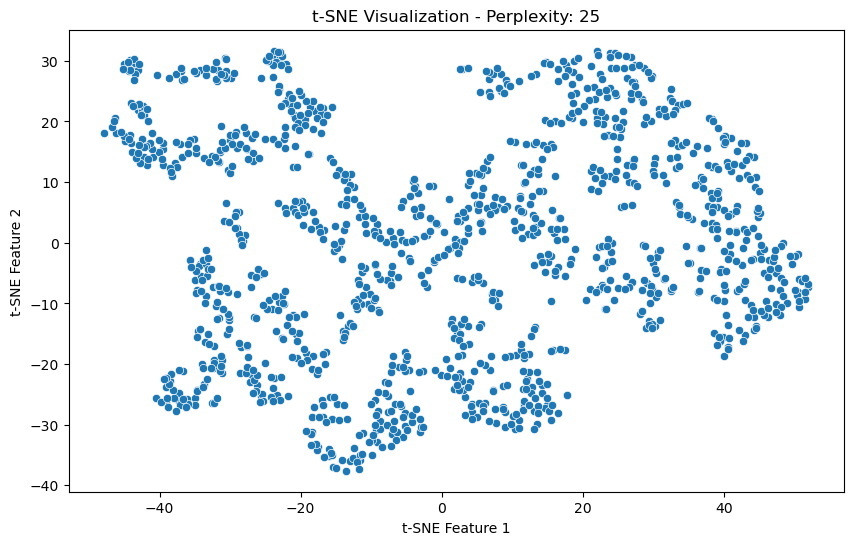

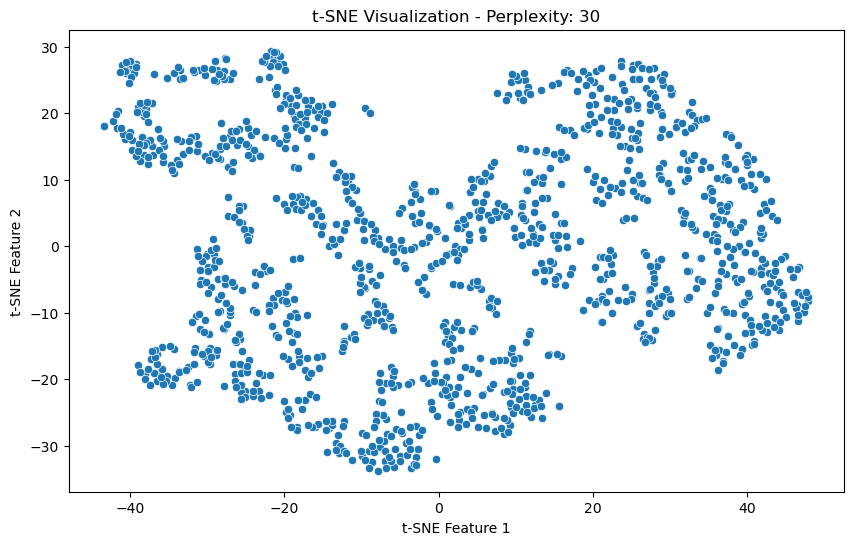

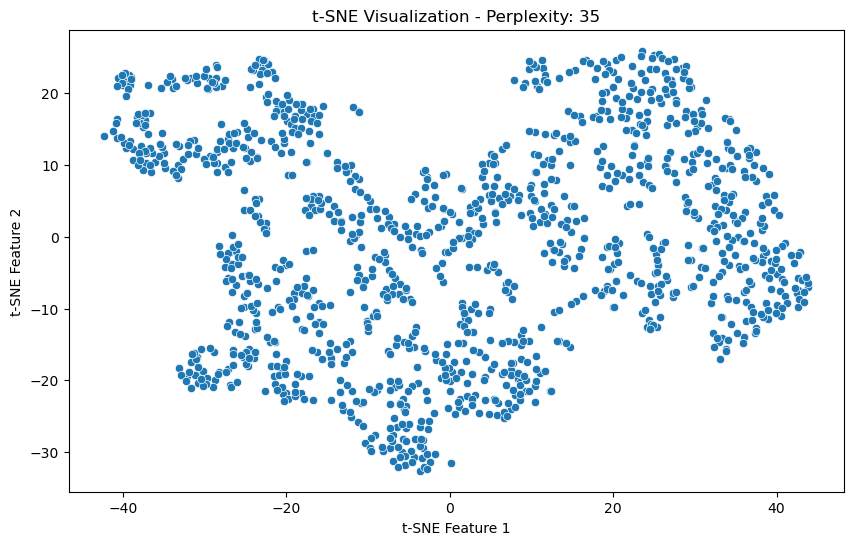

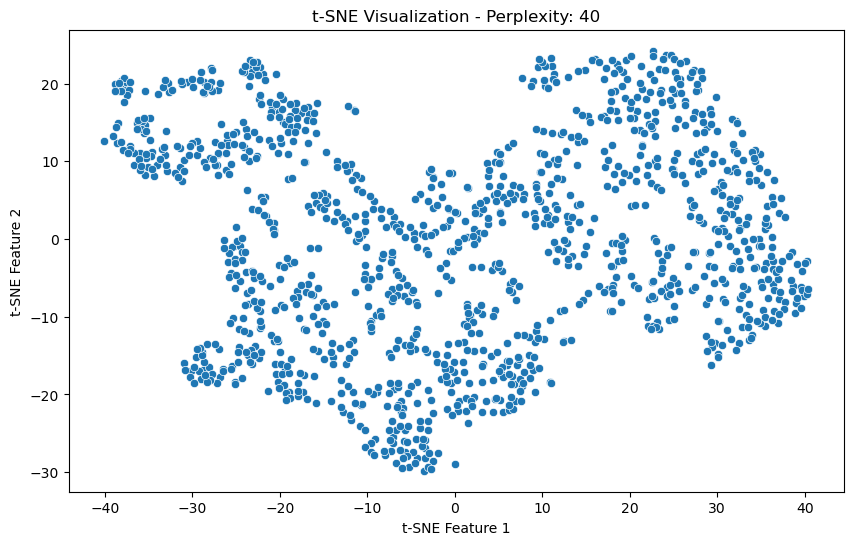

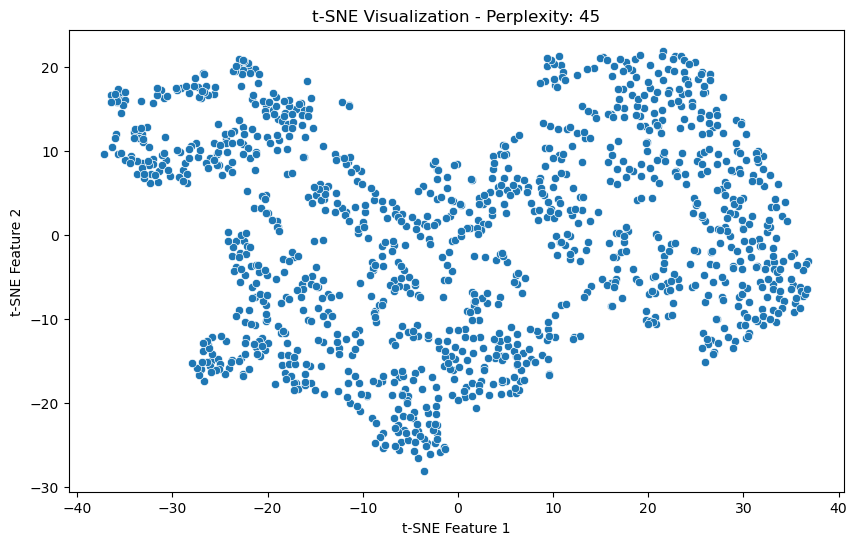

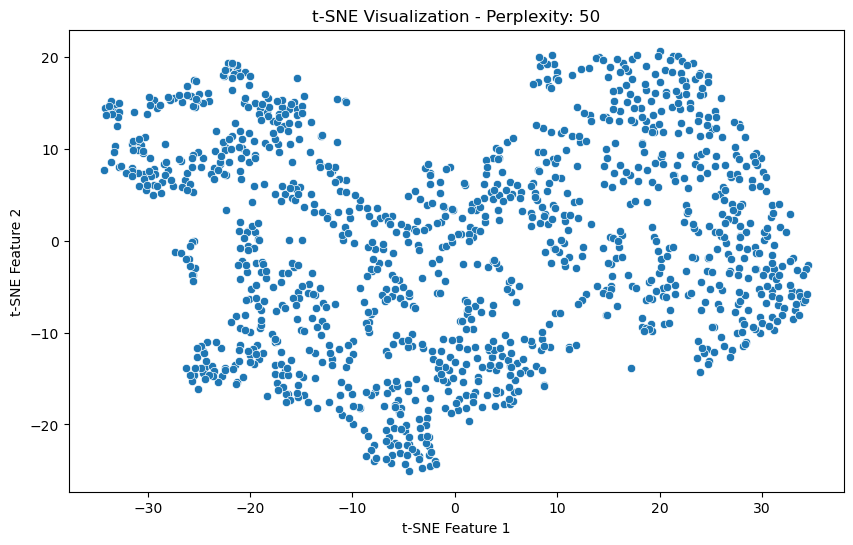

In [78]:
tsne_perplexities = [5,10,15,20,25,30,35,40,45,50]

for perplexity in tsne_perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1])
    plt.title(f't-SNE Visualization - Perplexity: {perplexity}')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.show()

## Kmeans with PCA|

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/d

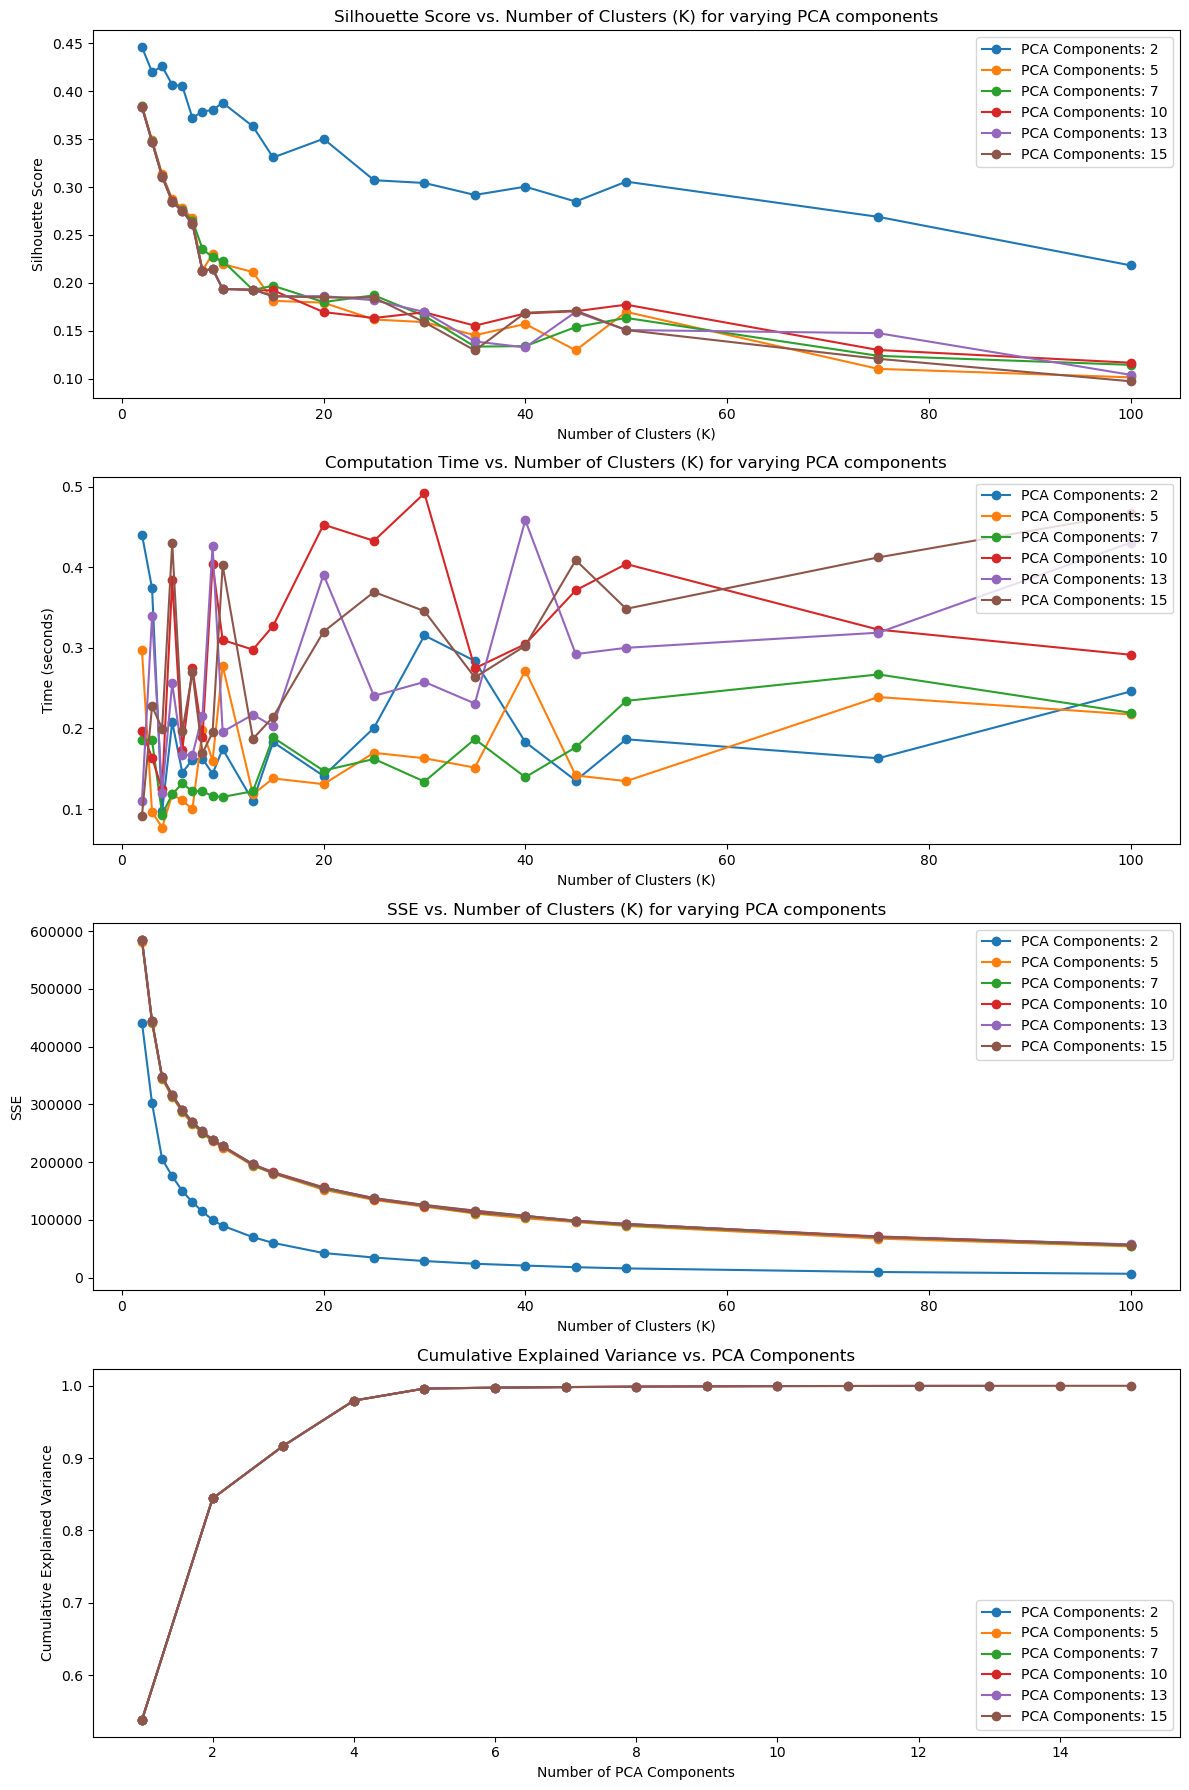

In [80]:
def kmeans_pca_silhouette_plot(X_train, X_test, y_test):
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    pca_components = [2, 5, 7, 10, 13, 15]  # Example PCA components list
    
    silhouette_scores_pca = {components: [] for components in pca_components}
    computation_times_pca = {components: [] for components in pca_components}
    explained_variances = []
    sse = {components: [] for components in pca_components}

    for components in pca_components:
        pca = PCA(n_components=components)
        X_train_pca = pca.fit_transform(X_train)
        explained_variances.append(np.cumsum(pca.explained_variance_ratio_))

        X_test_pca = pca.transform(X_test)
        
        for k in k_list:
            start_time = time.time()
            km_model = KMeans(n_clusters=k, random_state=42)
            km_model.fit(X_train_pca)
            km_pred = km_model.predict(X_test_pca)
            sse_val = km_model.inertia_
            elapsed_time = time.time() - start_time
            
            silhouette_avg = silhouette_score(X_test_pca, km_pred)
            sse[components].append(sse_val)
            silhouette_scores_pca[components].append(silhouette_avg)
            computation_times_pca[components].append(elapsed_time)

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 18))

    # Silhouette scores plot
    for components, scores in silhouette_scores_pca.items():
        ax1.plot(k_list, scores, marker='o', label=f'PCA Components: {components}')
    ax1.set_title('Silhouette Score vs. Number of Clusters (K) for varying PCA components')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Silhouette Score')
    ax1.legend()

    # Computation time plot
    for components, times in computation_times_pca.items():
        ax2.plot(k_list, times, marker='o', label=f'PCA Components: {components}')
    ax2.set_title('Computation Time vs. Number of Clusters (K) for varying PCA components')
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Time (seconds)')
    ax2.legend()

    # Computation time plot
    for components, errors in sse.items():
        ax3.plot(k_list, errors, marker='o', label=f'PCA Components: {components}')
    ax3.set_title('SSE vs. Number of Clusters (K) for varying PCA components')
    ax3.set_xlabel('Number of Clusters (K)')
    ax3.set_ylabel('SSE')
    ax3.legend()

    # Cumulative explained variance plot
    for i, variances in enumerate(explained_variances):
        ax4.plot(range(1, len(variances) + 1), variances, marker='o', label=f'PCA Components: {pca_components[i]}')
    ax4.set_title('Cumulative Explained Variance vs. PCA Components')
    ax4.set_xlabel('Number of PCA Components')
    ax4.set_ylabel('Cumulative Explained Variance')
    ax4.legend()

    plt.tight_layout()
    plt.show()


kmeans_pca_silhouette_plot(X_train, X_test, y_test)

## Expectation Maximization with PCA

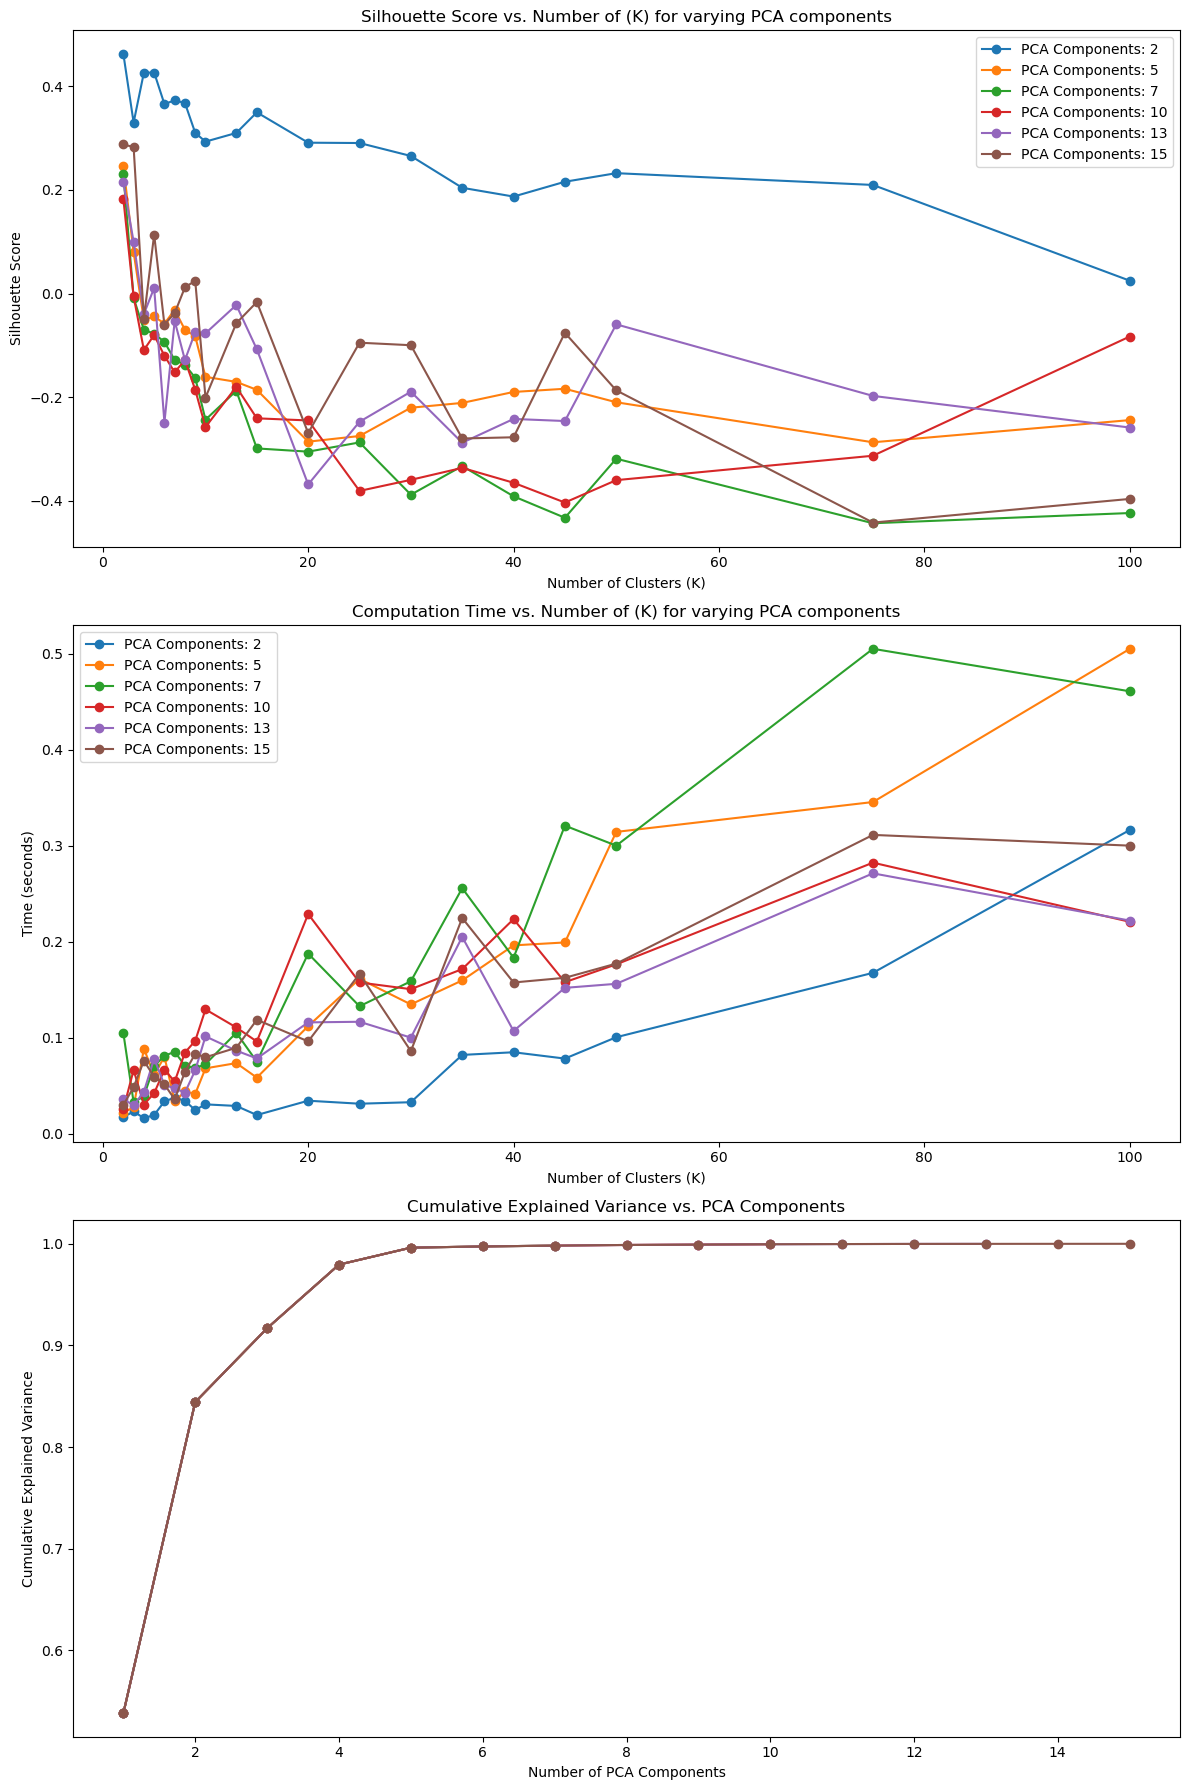

In [23]:
def gmm_pca_silhouette_plot(X_train, X_test, y_test):
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    pca_components = [2, 5, 7, 10, 13, 15]  # Example PCA components list
    
    silhouette_scores_pca = {components: [] for components in pca_components}
    computation_times_pca = {components: [] for components in pca_components}
    explained_variances = []

    for components in pca_components:
        pca = PCA(n_components=components)
        X_train_pca = pca.fit_transform(X_train)
        explained_variances.append(np.cumsum(pca.explained_variance_ratio_))

        X_test_pca = pca.transform(X_test)

        for k in k_list:
            start_time = time.time()
            gmm_model = GaussianMixture(n_components=k, random_state=42)
            gmm_model.fit(X_train_pca)
            gmm_pred = gmm_model.predict(X_test_pca)
            elapsed_time = time.time() - start_time
            
            unique_labels = np.unique(gmm_pred)
            if len(unique_labels) > 1:
                silhouette_avg = silhouette_score(X_test_pca, gmm_pred)
                silhouette_scores_pca[components].append(silhouette_avg)
            else:
                print(f"Skipping silhouette for PCA components={components} and k={k} due to single cluster prediction.")
                silhouette_scores_pca[components].append(None)  # Or some placeholder to indicate it was skipped
            computation_times_pca[components].append(elapsed_time)

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    # Silhouette scores plot
    for components, scores in silhouette_scores_pca.items():
        ax1.plot(k_list, scores, marker='o', label=f'PCA Components: {components}')
    ax1.set_title('Silhouette Score vs. Number of (K) for varying PCA components')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Silhouette Score')
    ax1.legend()

    # Computation time plot
    for components, times in computation_times_pca.items():
        ax2.plot(k_list, times, marker='o', label=f'PCA Components: {components}')
    ax2.set_title('Computation Time vs. Number of (K) for varying PCA components')
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Time (seconds)')
    ax2.legend()

    # Cumulative explained variance plot
    for i, variances in enumerate(explained_variances):
        ax3.plot(range(1, len(variances) + 1), variances, marker='o', label=f'PCA Components: {pca_components[i]}')
    ax3.set_title('Cumulative Explained Variance vs. PCA Components')
    ax3.set_xlabel('Number of PCA Components')
    ax3.set_ylabel('Cumulative Explained Variance')
    # ax3.legend()

    plt.tight_layout()
    plt.show()


gmm_pca_silhouette_plot(X_train, X_test, y_test)

## Kmeans with ICA

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/c

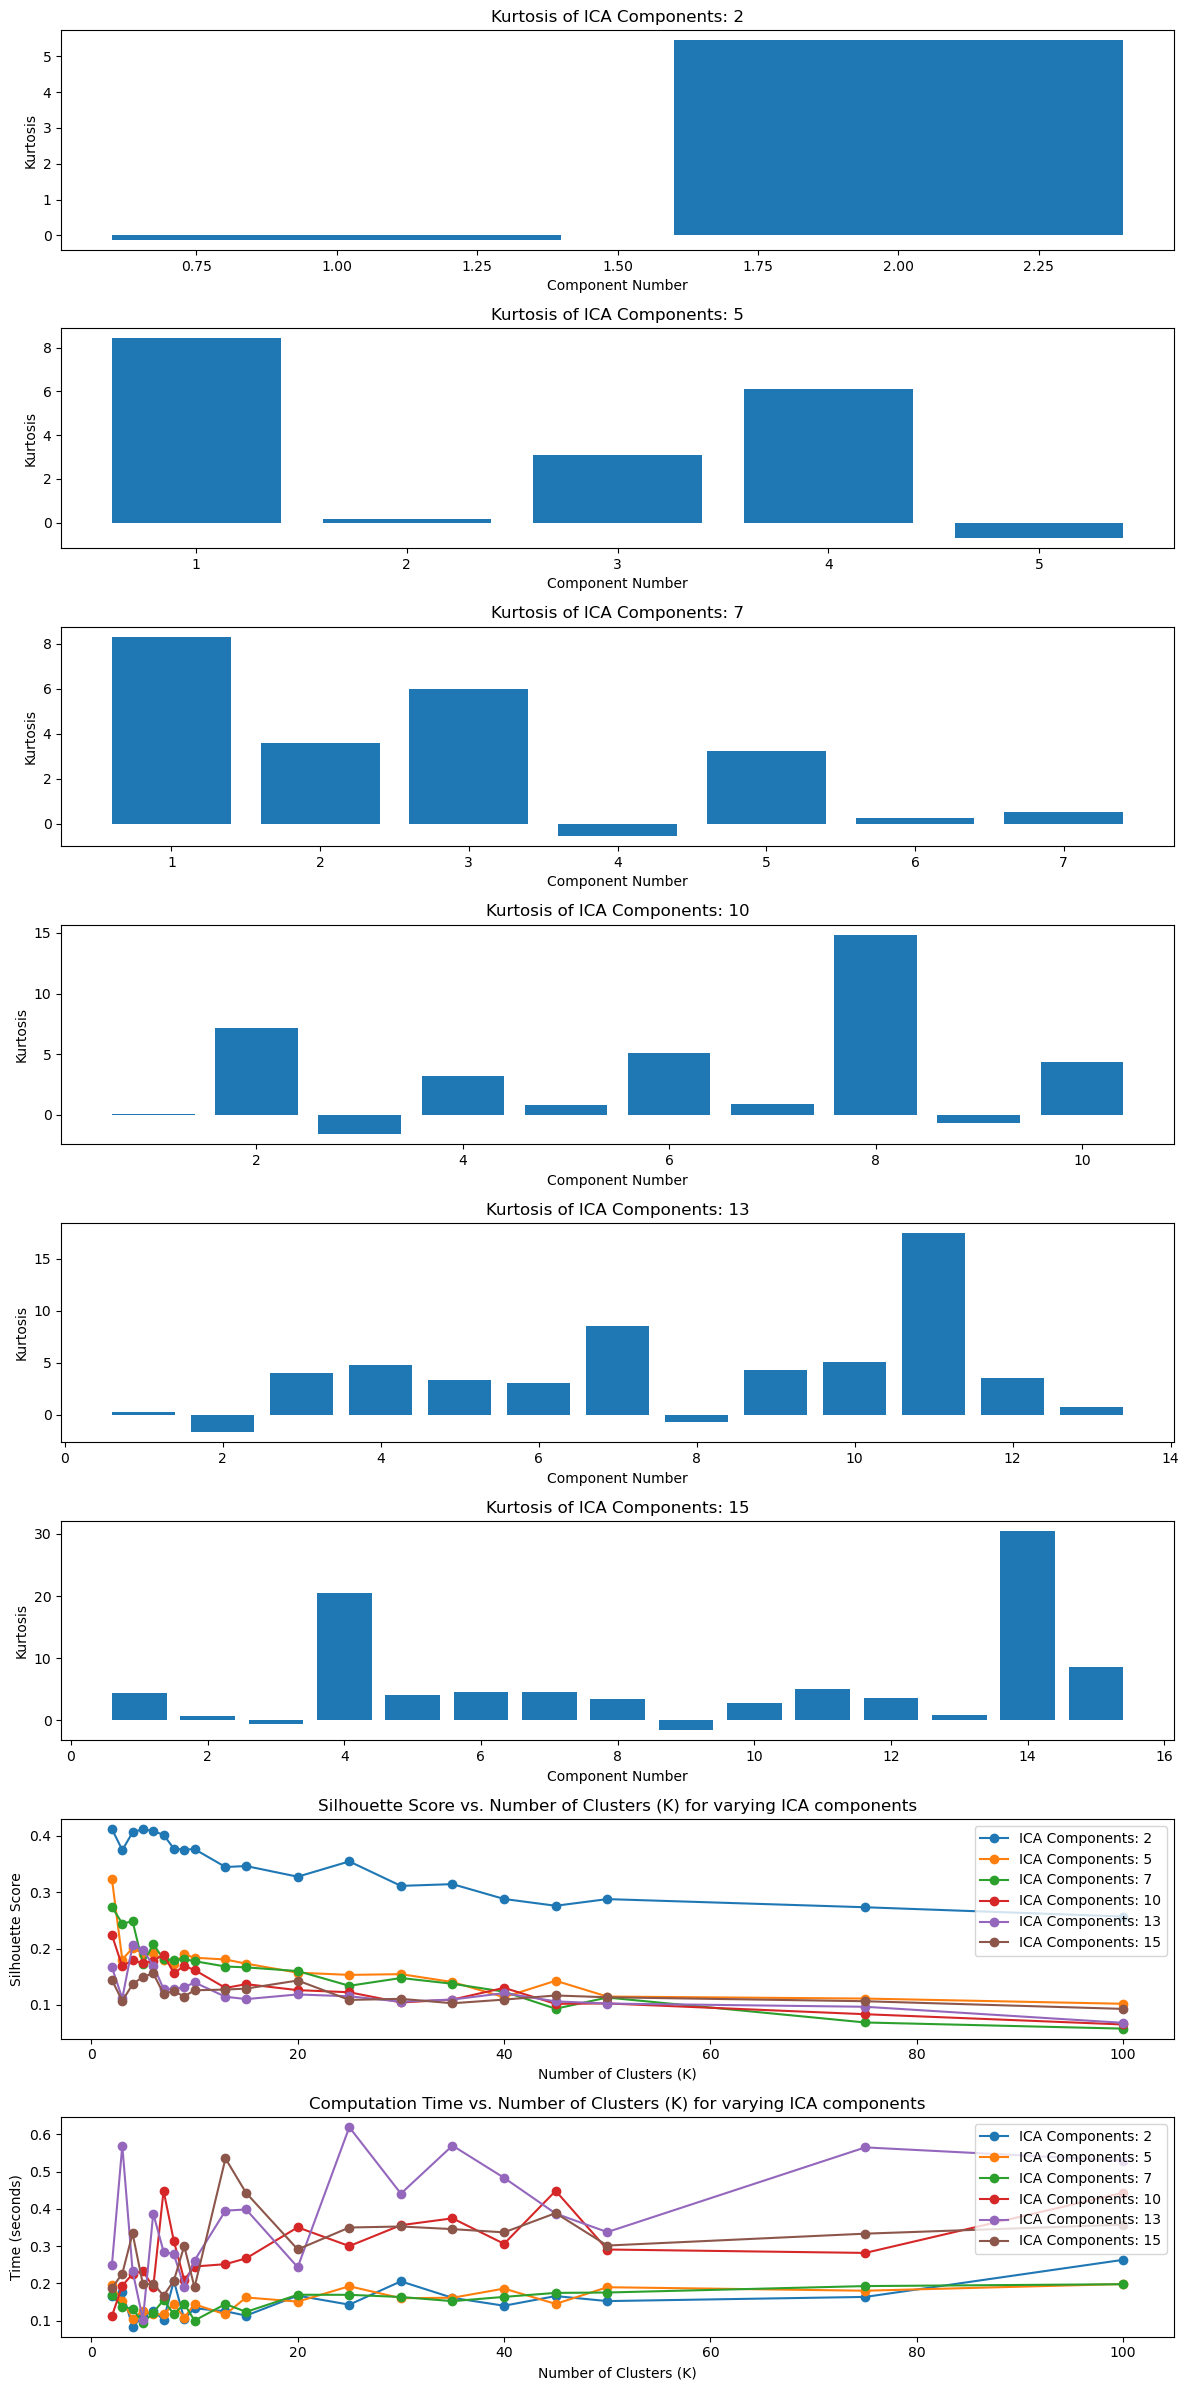

In [24]:
def kmeans_ica_silhouette_kurtosis_plot(X_train, X_test, y_test):
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    ica_components = [2, 5, 7, 10, 13, 15]  # Example ICA components list
    
    silhouette_scores_ica = {components: [] for components in ica_components}
    computation_times_ica = {components: [] for components in ica_components}
    kurtosis_results = {}

    # Kurtosis analysis
    for components in ica_components:
        ica = FastICA(n_components=components, random_state=42, max_iter=1000)
        X_train_ica = ica.fit_transform(X_train)
        kurt_vals = kurtosis(X_train_ica, axis=0, fisher=True)  # Using Fisher's definition
        kurtosis_results[components] = kurt_vals
        
        X_test_ica = ica.transform(X_test)
        
        for k in k_list:
            start_time = time.time()
            km_model = KMeans(n_clusters=k, random_state=42)
            km_model.fit(X_train_ica)
            km_pred = km_model.predict(X_test_ica)
            elapsed_time = time.time() - start_time
            
            silhouette_avg = silhouette_score(X_test_ica, km_pred)
            silhouette_scores_ica[components].append(silhouette_avg)
            computation_times_ica[components].append(elapsed_time)

    # Plotting
    fig, axs = plt.subplots(len(ica_components) + 2, 1, figsize=(12, 3 * (len(ica_components) + 2)))

    # Kurtosis plot for each ICA component setting
    for i, (components, kurt_vals) in enumerate(kurtosis_results.items()):
        # axs[i].bar(range(1, components + 1), kurt_vals)
        axs[i].bar(range(1, len(kurt_vals) + 1), kurt_vals)

        axs[i].set_title(f'Kurtosis of ICA Components: {components}')
        axs[i].set_xlabel('Component Number')
        axs[i].set_ylabel('Kurtosis')

    # Silhouette scores plot
    ax_sil = axs[-2]
    for components, scores in silhouette_scores_ica.items():
        ax_sil.plot(k_list, scores, marker='o', label=f'ICA Components: {components}')
    ax_sil.set_title('Silhouette Score vs. Number of Clusters (K) for varying ICA components')
    ax_sil.set_xlabel('Number of Clusters (K)')
    ax_sil.set_ylabel('Silhouette Score')
    ax_sil.legend()

    # Computation time plot
    ax_time = axs[-1]
    for components, times in computation_times_ica.items():
        ax_time.plot(k_list, times, marker='o', label=f'ICA Components: {components}')
    ax_time.set_title('Computation Time vs. Number of Clusters (K) for varying ICA components')
    ax_time.set_xlabel('Number of Clusters (K)')
    ax_time.set_ylabel('Time (seconds)')
    ax_time.legend()

    plt.tight_layout()
    plt.show()

# Assuming X_train, X_test, y_test are defined, call the function with your data
kmeans_ica_silhouette_kurtosis_plot(X_train, X_test, y_test)

## EM with ICA

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/d

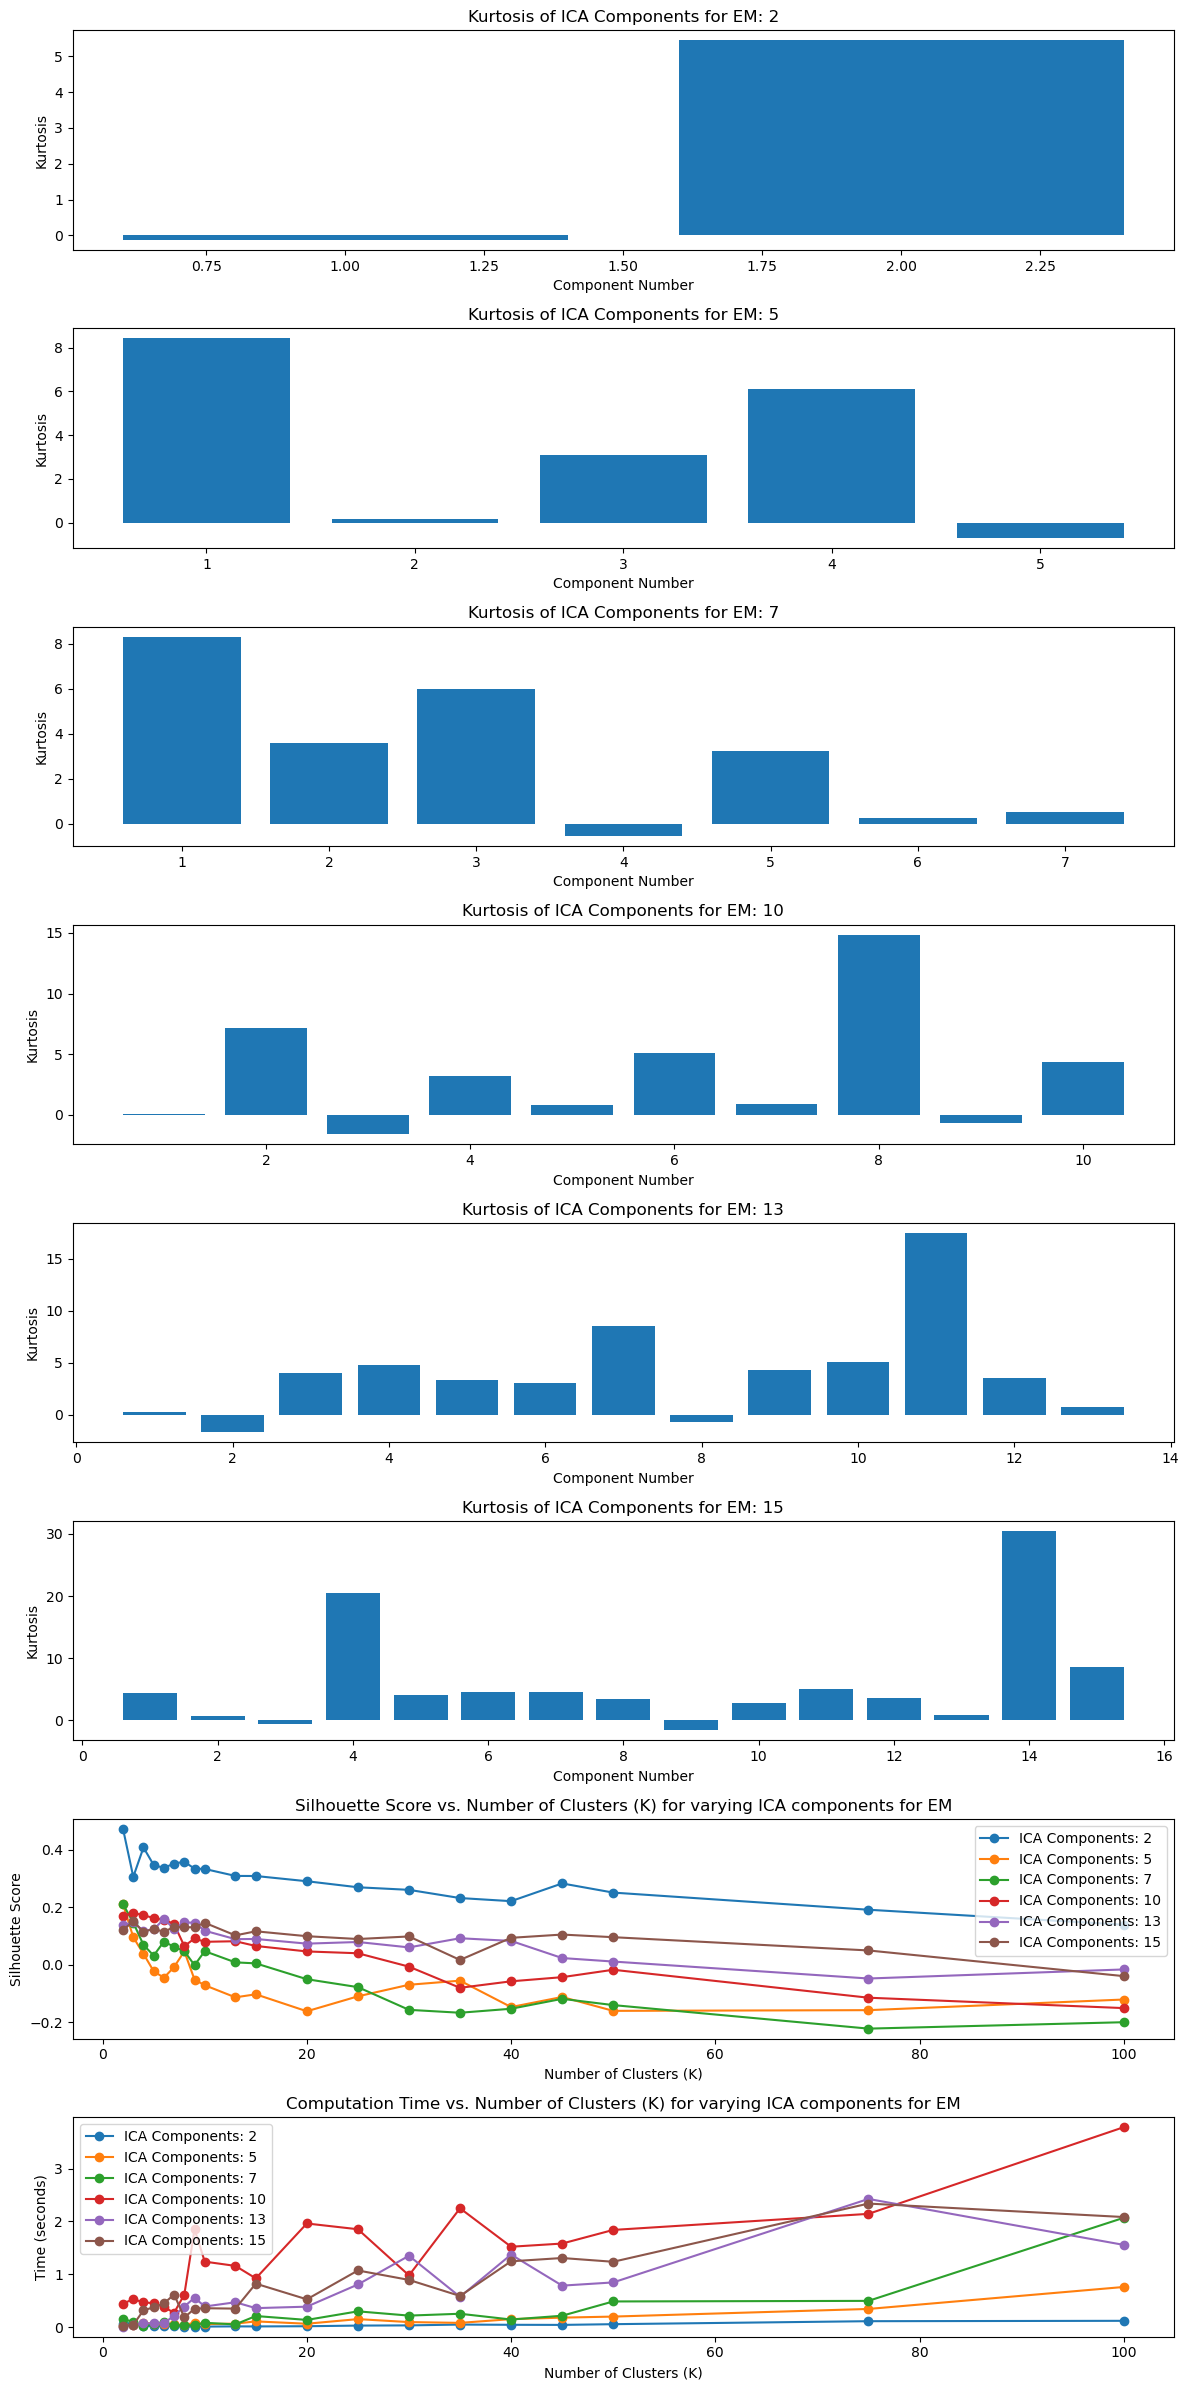

In [25]:
def gmm_ica_silhouette_kurtosis_plot(X_train, X_test, y_test):
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    ica_components = [2, 5, 7, 10, 13, 15]  # Example ICA components list
    
    silhouette_scores_ica = {components: [] for components in ica_components}
    computation_times_ica = {components: [] for components in ica_components}
    kurtosis_results = {}

    # Kurtosis analysis
    for components in ica_components:
        ica = FastICA(n_components=components, random_state=42, max_iter=1000)
        X_train_ica = ica.fit_transform(X_train)
        kurt_vals = kurtosis(X_train_ica, axis=0, fisher=True)  # Using Fisher's definition
        kurtosis_results[components] = kurt_vals
        
        X_test_ica = ica.transform(X_test)
        
        for k in k_list:
            start_time = time.time()
            gmm_model = GaussianMixture(n_components=k, random_state=42)
            gmm_model.fit(X_train_ica)
            gmm_pred = gmm_model.predict(X_test_ica)
            elapsed_time = time.time() - start_time
            
            silhouette_avg = silhouette_score(X_test_ica, gmm_pred)
            silhouette_scores_ica[components].append(silhouette_avg)
            computation_times_ica[components].append(elapsed_time)

    # Plotting
    fig, axs = plt.subplots(len(ica_components) + 2, 1, figsize=(12, 3 * (len(ica_components) + 2)))

    # Kurtosis plot for each ICA component setting
    for i, (components, kurt_vals) in enumerate(kurtosis_results.items()):
        # axs[i].bar(range(1, components + 1), kurt_vals)
        axs[i].bar(range(1, len(kurt_vals) + 1), kurt_vals)

        axs[i].set_title(f'Kurtosis of ICA Components for EM: {components}')
        axs[i].set_xlabel('Component Number')
        axs[i].set_ylabel('Kurtosis')

    # Silhouette scores plot
    ax_sil = axs[-2]
    for components, scores in silhouette_scores_ica.items():
        ax_sil.plot(k_list, scores, marker='o', label=f'ICA Components: {components}')
    ax_sil.set_title('Silhouette Score vs. Number of Clusters (K) for varying ICA components for EM')
    ax_sil.set_xlabel('Number of Clusters (K)')
    ax_sil.set_ylabel('Silhouette Score')
    ax_sil.legend()

    # Computation time plot
    ax_time = axs[-1]
    for components, times in computation_times_ica.items():
        ax_time.plot(k_list, times, marker='o', label=f'ICA Components: {components}')
    ax_time.set_title('Computation Time vs. Number of Clusters (K) for varying ICA components for EM')
    ax_time.set_xlabel('Number of Clusters (K)')
    ax_time.set_ylabel('Time (seconds)')
    ax_time.legend()

    plt.tight_layout()
    plt.show()

# Assuming X_train, X_test, y_test are defined, call the function with your data
gmm_ica_silhouette_kurtosis_plot(X_train, X_test, y_test)

## KMeans with RP

In [75]:
import time
def kmeans_random_projection_silhouette_error_plot(X_train, X_test, y_test):
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    rp_components = [2, 5, 7, 10, 13, 15]  # Example RP components list

    silhouette_scores_rp = {components: [] for components in rp_components}
    computation_times_rp = {components: [] for components in rp_components}
    reconstruction_errors = []

    # Random Projection analysis
    for components in rp_components:
        rp = GaussianRandomProjection(n_components=components, random_state=42)
        X_train_rp = rp.fit_transform(X_train)
        X_test_rp = rp.transform(X_test)

        # Reconstruction using pseudo-inverse
        components_matrix = rp.components_
        pseudo_inverse_matrix = np.linalg.pinv(components_matrix)
        # Correction: Ensure correct matrix alignment for dot product
        X_train_reconstructed = np.dot(X_train_rp, pseudo_inverse_matrix.T)
        error = mean_squared_error(X_train, X_train_reconstructed)
        data_variance = np.var(X_train, axis=0).sum()

# If the data variance is zero (which is unusual for real datasets),
# it implies that the data is constant, and the error is set to zero.
        normalized_error = error / data_variance if data_variance != 0 else 0
        reconstruction_errors.append(normalized_error)

        for k in k_list:
            start_time = time.time()
            km_model = KMeans(n_clusters=k, random_state=42)
            km_model.fit(X_train_rp)
            km_pred = km_model.predict(X_test_rp)
            elapsed_time = time.time() - start_time

            silhouette_avg = silhouette_score(X_test_rp, km_pred)
            silhouette_scores_rp[components].append(silhouette_avg)
            computation_times_rp[components].append(elapsed_time)

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Silhouette scores plot
    for components, scores in silhouette_scores_rp.items():
        axs[0].plot(k_list, scores, marker='o', label=f'RP Components: {components}')
    axs[0].set_title('Silhouette Score vs. Number of Clusters (K) for varying RP components')
    axs[0].set_xlabel('Number of Clusters (K)')
    axs[0].set_ylabel('Silhouette Score')
    axs[0].legend()

    # Computation time plot
    for components, times in computation_times_rp.items():
        axs[1].plot(k_list, times, marker='o', label=f'RP Components: {components}')
    axs[1].set_title('Computation Time vs. Number of Clusters (K) for varying RP components')
    axs[1].set_xlabel('Number of Clusters (K)')
    axs[1].set_ylabel('Time (seconds)')
    axs[1].legend()

    # Reconstruction error plot
    axs[2].plot(rp_components, reconstruction_errors, marker='o', linestyle='-', color='orange')
    axs[2].set_title('Reconstruction Error vs. Number of RP Components')
    axs[2].set_xlabel('Number of RP Components')
    axs[2].set_ylabel('Reconstruction Error (MSE)')
    axs[2].set_xticks(rp_components)

    plt.tight_layout()
    plt.show()

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/d

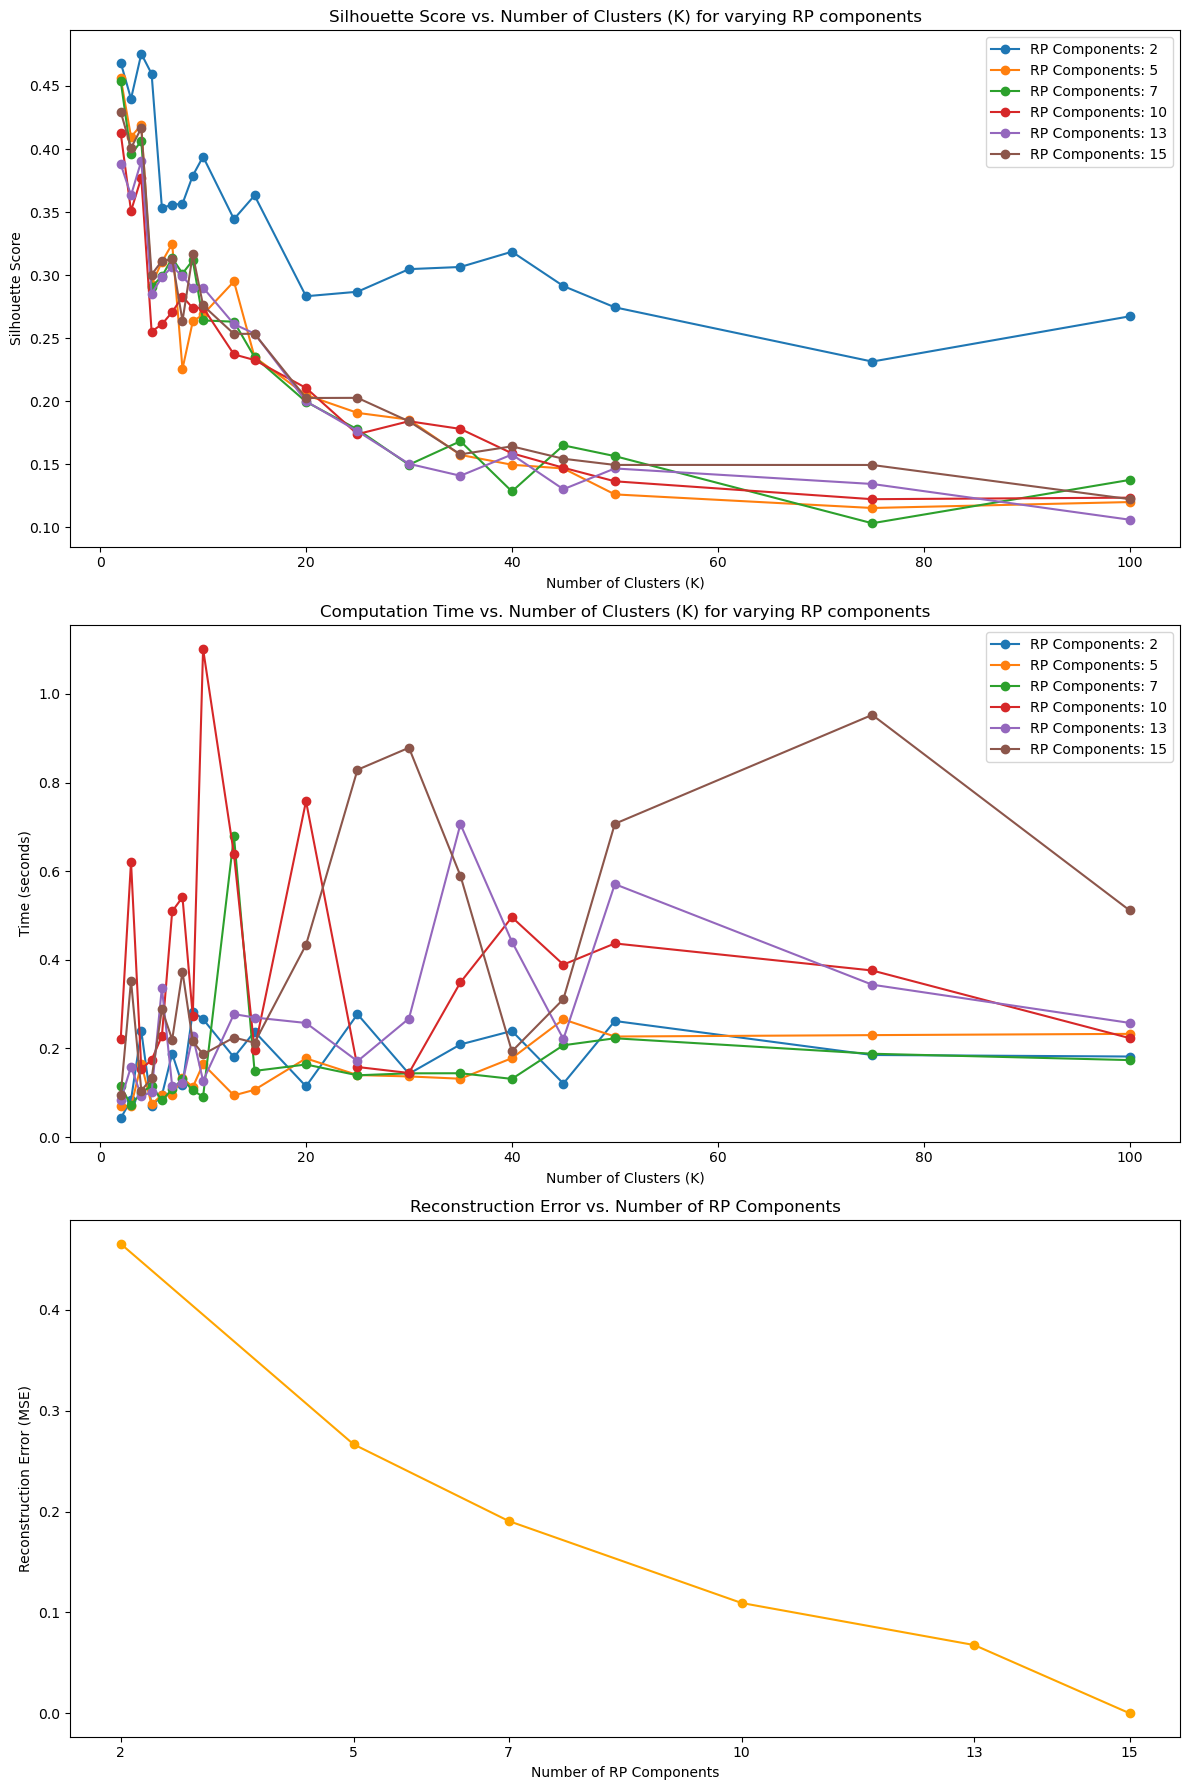

In [76]:
kmeans_random_projection_silhouette_error_plot(X_train, X_test, y_test)

## EM with RP


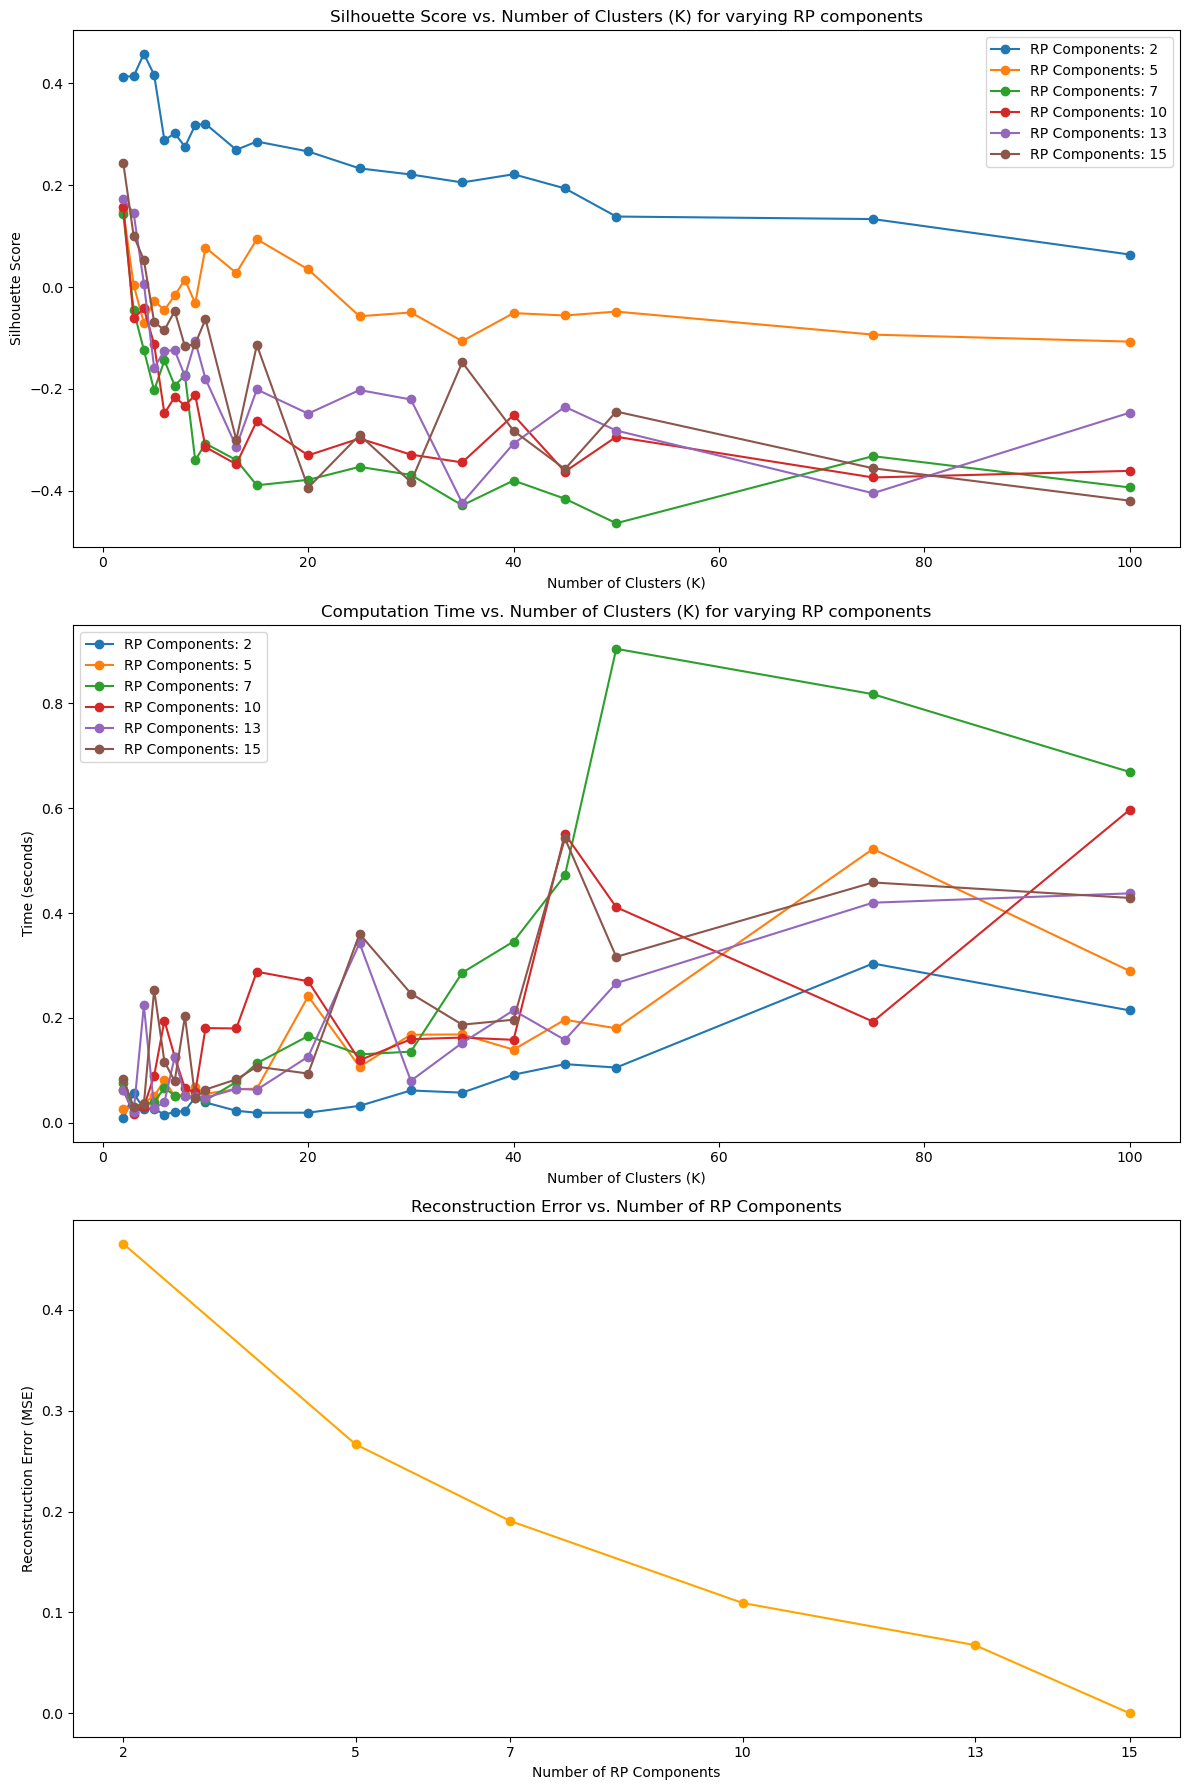

In [74]:
import time
def em_random_projection_silhouette_error_plot(X_train, X_test, y_test):
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    rp_components = [2, 5, 7, 10, 13, 15]  # Example RP components list

    silhouette_scores_rp = {components: [] for components in rp_components}
    computation_times_rp = {components: [] for components in rp_components}
    reconstruction_errors = []

    # Random Projection analysis
    for components in rp_components:
        rp = GaussianRandomProjection(n_components=components, random_state=42)
        X_train_rp = rp.fit_transform(X_train)
        X_test_rp = rp.transform(X_test)

        # Reconstruction using pseudo-inverse
        components_matrix = rp.components_
        pseudo_inverse_matrix = np.linalg.pinv(components_matrix)
        X_train_reconstructed = np.dot(X_train_rp, pseudo_inverse_matrix.T)
        error = mean_squared_error(X_train, X_train_reconstructed)
        data_variance = np.var(X_train, axis=0).sum()

# If the data variance is zero (which is unusual for real datasets),
# it implies that the data is constant, and the error is set to zero.
        normalized_error = error / data_variance if data_variance != 0 else 0
        reconstruction_errors.append(normalized_error)

        for k in k_list:
            start_time = time.time()
            em_model = GaussianMixture(n_components=k, random_state=42)
            em_model.fit(X_train_rp)
            # Instead of predict, we use predict_proba to get the likelihood of each component
            # This will return the likelihood of each sample being in each cluster
            em_pred = em_model.predict_proba(X_test_rp)
            # Assign each sample to the cluster with the max likelihood
            em_pred = np.argmax(em_pred, axis=1)
            elapsed_time = time.time() - start_time

            silhouette_avg = silhouette_score(X_test_rp, em_pred)
            silhouette_scores_rp[components].append(silhouette_avg)
            computation_times_rp[components].append(elapsed_time)

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Silhouette scores plot
    for components, scores in silhouette_scores_rp.items():
        axs[0].plot(k_list, scores, marker='o', label=f'RP Components: {components}')
    axs[0].set_title('Silhouette Score vs. Number of Clusters (K) for varying RP components')
    axs[0].set_xlabel('Number of Clusters (K)')
    axs[0].set_ylabel('Silhouette Score')
    axs[0].legend()

    # Computation time plot
    for components, times in computation_times_rp.items():
        axs[1].plot(k_list, times, marker='o', label=f'RP Components: {components}')
    axs[1].set_title('Computation Time vs. Number of Clusters (K) for varying RP components')
    axs[1].set_xlabel('Number of Clusters (K)')
    axs[1].set_ylabel('Time (seconds)')
    axs[1].legend()

    # Reconstruction error plot
    axs[2].plot(rp_components, reconstruction_errors, marker='o', linestyle='-', color='orange')
    axs[2].set_title('Reconstruction Error vs. Number of RP Components')
    axs[2].set_xlabel('Number of RP Components')
    axs[2].set_ylabel('Reconstruction Error (MSE)')
    axs[2].set_xticks(rp_components)

    plt.tight_layout()
    plt.show()

# Replace with your actual data before calling the function
em_random_projection_silhouette_error_plot(X_train, X_test, y_test)

## Kmeans with tsne

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/d

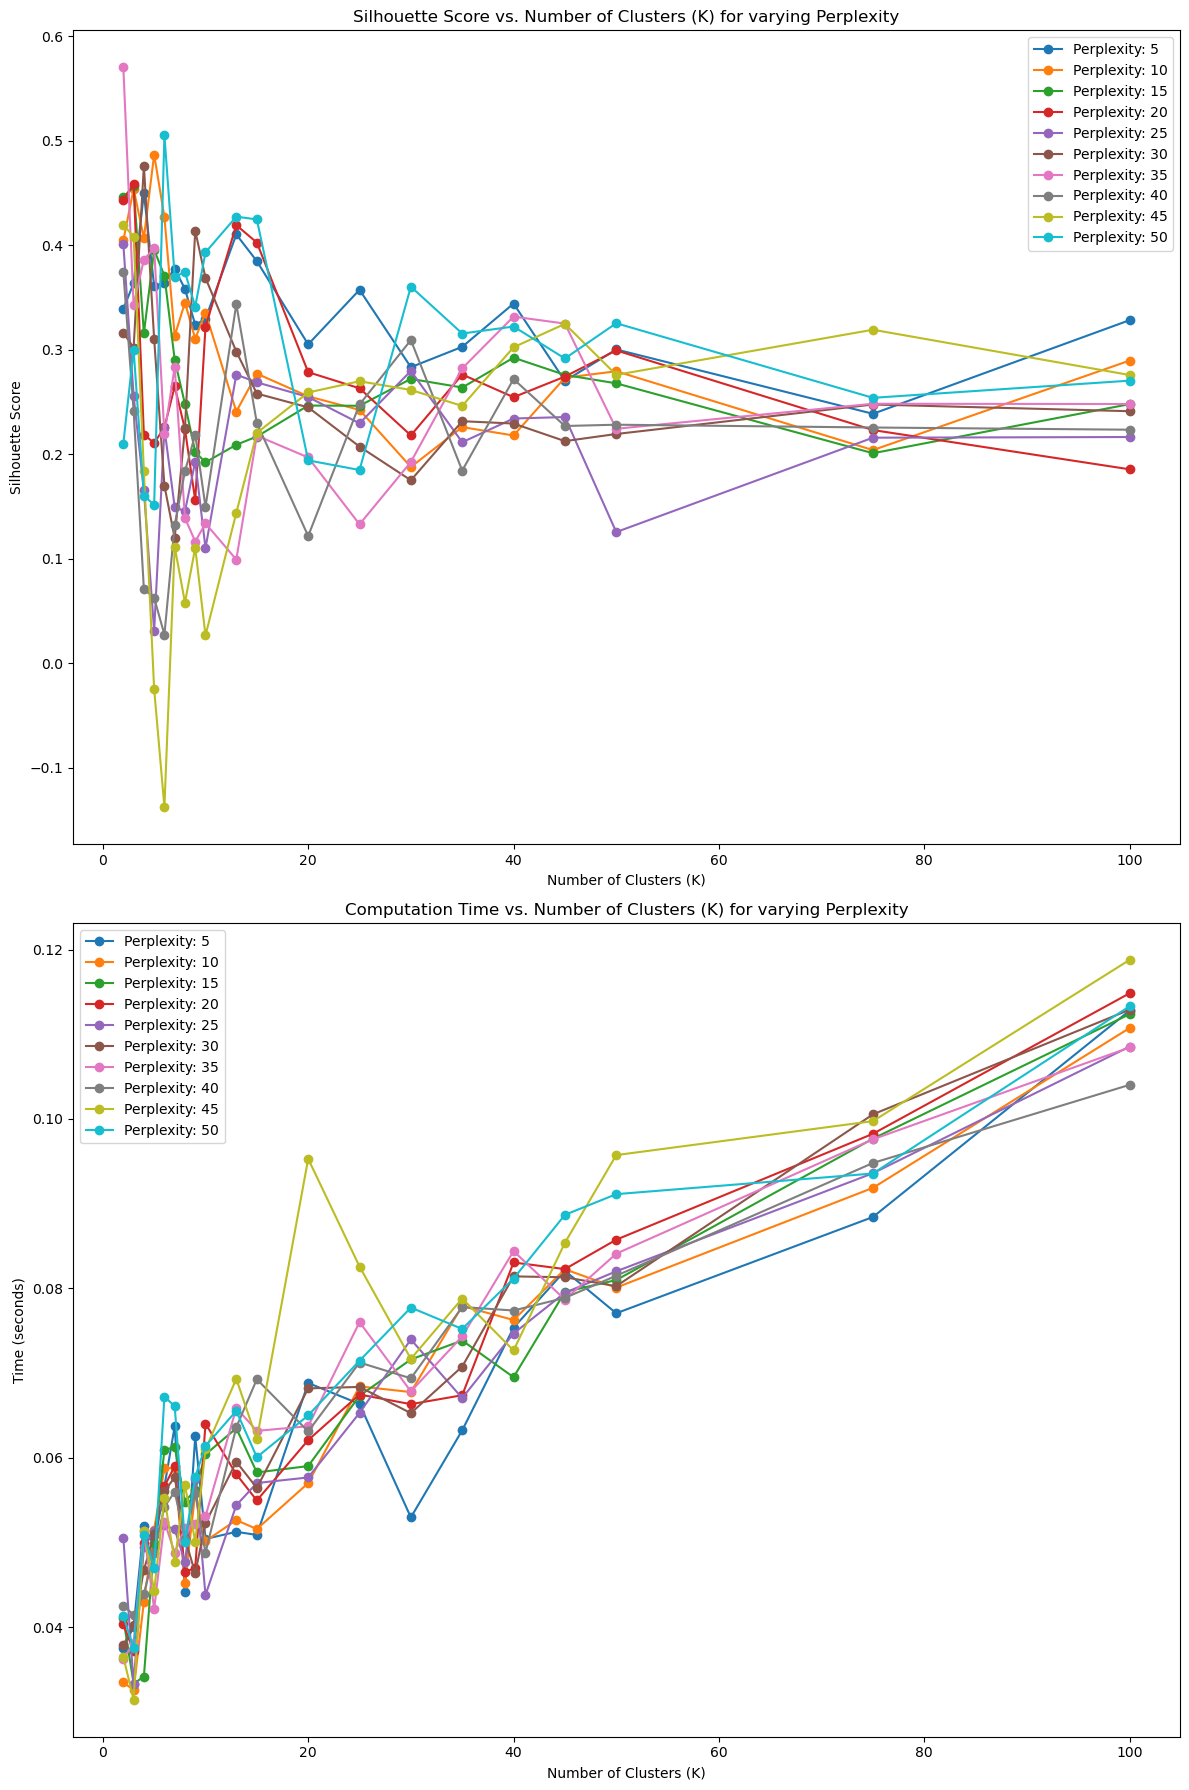

In [34]:
import time as TT


def kmeans_tsne_silhouette_plot(X_train, X_test, y_test):
    
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    tsne_components = [5,10,15,20,25,30,35,40,45,50]  # Example t-SNE perplexity list
    
    silhouette_scores_tsne = {components: [] for components in tsne_components}
    computation_times_tsne = {components: [] for components in tsne_components}

    # Iterate through t-SNE perplexities
    for perplexity in tsne_components:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        X_train_tsne = tsne.fit_transform(X_train)
        X_test_tsne = tsne.fit_transform(X_test)  # Note: t-SNE doesn't support transform method. This is for illustration.

        # Iterate through k_list for KMeans
        for k in k_list:
            start_time = TT.time()
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X_train_tsne)
            km_pred = kmeans.predict(X_test_tsne)  # Adjusted to use X_train_tsne
            elapsed_time = TT.time() - start_time
            
            silhouette_avg = silhouette_score(X_test_tsne, km_pred)
            silhouette_scores_tsne[perplexity].append(silhouette_avg)
            computation_times_tsne[perplexity].append(elapsed_time)

    # Plotting Silhouette Scores
    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 18))

    # Silhouette scores plot
    for components, scores in silhouette_scores_tsne.items():
        axs[0].plot(k_list, scores, marker='o', label=f'Perplexity: {components}')
    axs[0].set_title('Silhouette Score vs. Number of Clusters (K) for varying Perplexity')
    axs[0].set_xlabel('Number of Clusters (K)')
    axs[0].set_ylabel('Silhouette Score')
    axs[0].legend()

    # Computation time plot
    for components, times in computation_times_tsne.items():
        axs[1].plot(k_list, times, marker='o', label=f'Perplexity: {components}')
    axs[1].set_title('Computation Time vs. Number of Clusters (K) for varying Perplexity')
    axs[1].set_xlabel('Number of Clusters (K)')
    axs[1].set_ylabel('Time (seconds)')
    axs[1].legend()

    # Reconstruction error plot
    # axs[2].plot(rp_components, reconstruction_errors, marker='o', linestyle='-', color='orange')
    # axs[2].set_title('Reconstruction Error vs. Number of Perplexity')
    # axs[2].set_xlabel('Number of RP Components')
    # axs[2].set_ylabel('Reconstruction Error (MSE)')
    # axs[2].set_xticks(rp_components)

    plt.tight_layout()
    plt.show()
# Replace X_train, X_test, y_test with your actual datasets
kmeans_tsne_silhouette_plot(X_train, X_test, y_test)

## EM with TSNE

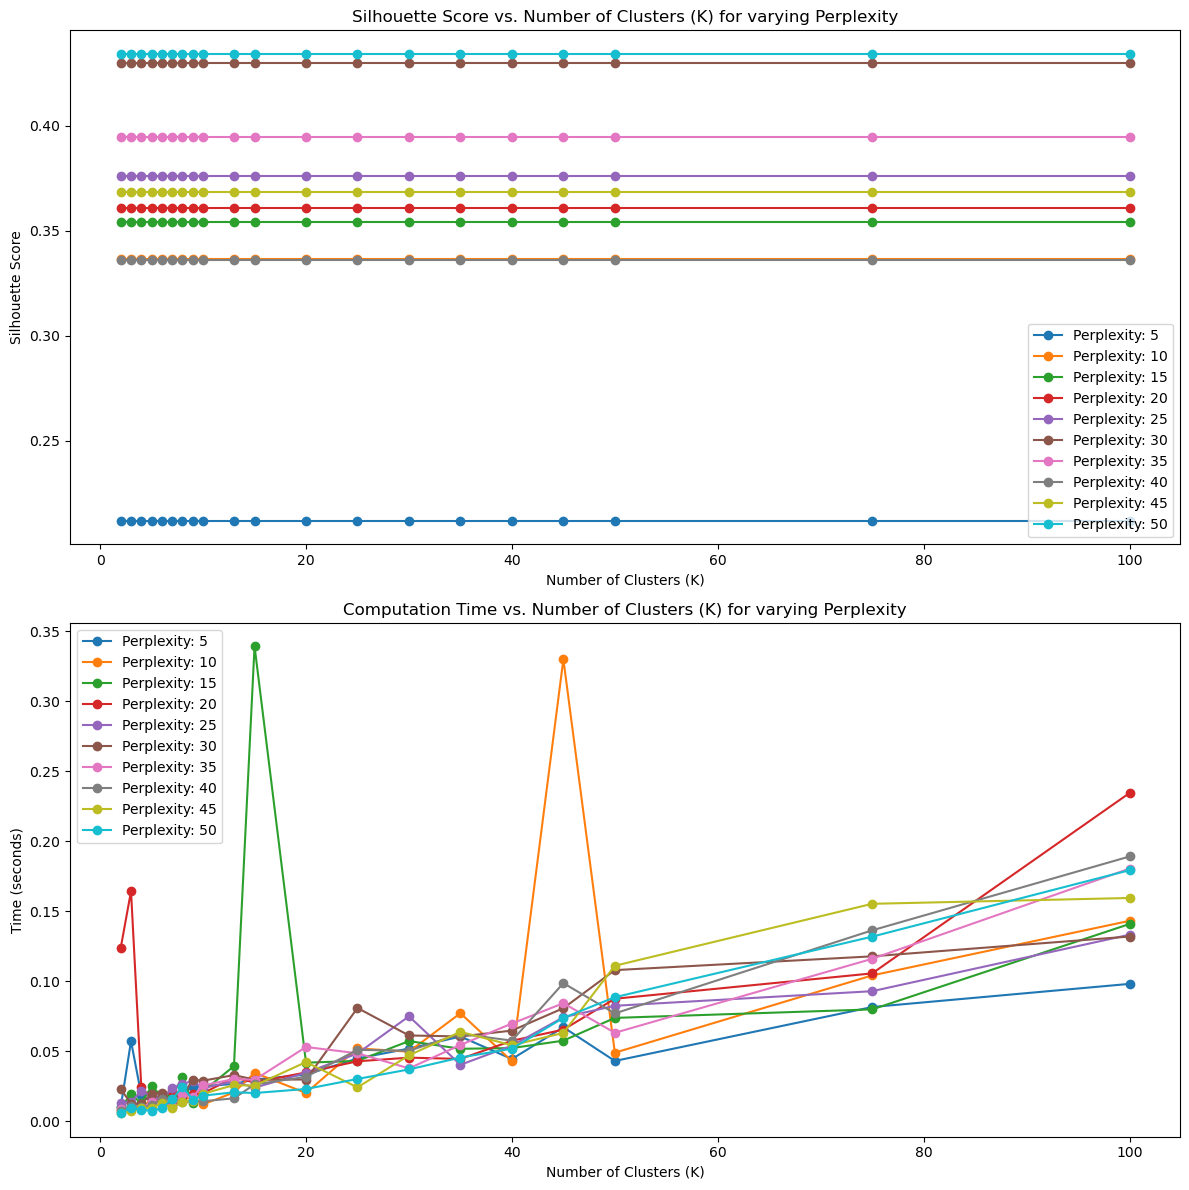

In [79]:
import time as TT


def em_tsne_silhouette_plot(X_train, X_test, y_test):
    
    k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
    tsne_components = [5,10,15,20,25,30,35,40,45,50]  # Example t-SNE perplexity list
    
    silhouette_scores_tsne = {components: [] for components in tsne_components}
    computation_times_tsne = {components: [] for components in tsne_components}

    # Iterate through t-SNE perplexities
    for perplexity in tsne_components:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        X_train_tsne = tsne.fit_transform(X_train)
        X_test_tsne = tsne.fit_transform(X_test)  # Note: t-SNE doesn't support transform method. This is for illustration.

        # Iterate through k_list for KMeans
        for k in k_list:
            start_time = TT.time()
            em_model = GaussianMixture(n_components=k, random_state=42)
            em_model.fit(X_train_tsne)
            # Instead of predict, we use predict_proba to get the likelihood of each component
            # This will return the likelihood of each sample being in each cluster
            em_pred = em_model.predict_proba(X_test_tsne)
            # Assign each sample to the cluster with the max likelihood
            em_pred = np.argmax(em_pred, axis=1)
            elapsed_time = TT.time() - start_time
            
            silhouette_avg = silhouette_score(X_test_tsne, km_pred)
            silhouette_scores_tsne[perplexity].append(silhouette_avg)
            computation_times_tsne[perplexity].append(elapsed_time)

    # Plotting Silhouette Scores
    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    # Silhouette scores plot
    for components, scores in silhouette_scores_tsne.items():
        axs[0].plot(k_list, scores, marker='o', label=f'Perplexity: {components}')
    axs[0].set_title('Silhouette Score vs. Number of Clusters (K) for varying Perplexity')
    axs[0].set_xlabel('Number of Clusters (K)')
    axs[0].set_ylabel('Silhouette Score')
    axs[0].legend()

    # Computation time plot
    for components, times in computation_times_tsne.items():
        axs[1].plot(k_list, times, marker='o', label=f'Perplexity: {components}')
    axs[1].set_title('Computation Time vs. Number of Clusters (K) for varying Perplexity')
    axs[1].set_xlabel('Number of Clusters (K)')
    axs[1].set_ylabel('Time (seconds)')
    axs[1].legend()

    # Reconstruction error plot
    # axs[2].plot(rp_components, reconstruction_errors, marker='o', linestyle='-', color='orange')
    # axs[2].set_title('Reconstruction Error vs. Number of Perplexity')
    # axs[2].set_xlabel('Number of RP Components')
    # axs[2].set_ylabel('Reconstruction Error (MSE)')
    # axs[2].set_xticks(rp_components)

    plt.tight_layout()
    plt.show()
# Replace X_train, X_test, y_test with your actual datasets
em_tsne_silhouette_plot(X_train, X_test, y_test)

## NN with PCA, ICA, RP, TSNE

In [86]:

model_nn = MLPClassifier()
param_nn = {
	'alpha': [1e-05,1e-04,1e-03,1e-02,1e-01,1,2,3],
	'learning_rate_init': [0.001,0.01,0.1,1],
	'activation': ['tanh', 'relu']
}


In [87]:
GSNN = GridSearchCV(model_nn, param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
start = time.time()
GSNN.fit(X_train, y_train)
print('time: ', time.time()-start)
print('best_param:', GSNN.best_params_)
print('best_score:', GSNN.best_score_)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda

time:  6.59928822517395
best_param: {'activation': 'tanh', 'alpha': 3, 'learning_rate_init': 0.001}
best_score: 0.8398061104582843


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
pred_nn = GSNN.predict(X_test)
print(classification_report(y_test, pred_nn))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       159
           1       0.88      0.75      0.81       149

    accuracy                           0.83       308
   macro avg       0.84      0.83      0.83       308
weighted avg       0.84      0.83      0.83       308



In [33]:
import time as time
def nn_pca_classification_report_summary(X_train, X_test, y_train, y_test):
    pca_components = [2, 5, 7, 10, 13, 15]
    param_nn = {
        'alpha': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 2, 3],
        'learning_rate_init': [0.001, 0.01, 0.1, 1],
        'activation': ['tanh', 'relu']
    }
    n_thread = -1  # Use all available CPUs
    
    accuracy_scores_pca = []
    computation_times_pca = []
    f1_scores_label_1 = []
    f1_scores_label_2 = []

    for components in pca_components:
        pca = PCA(n_components=components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        GSNN = GridSearchCV(MLPClassifier(max_iter=1000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
        start_time = time.time()
        GSNN.fit(X_train_pca, y_train)
        pred_nn = GSNN.predict(X_test_pca)
        elapsed_time = time.time() - start_time

        accuracy = accuracy_score(y_test, pred_nn)
        f1 = f1_score(y_test, pred_nn, average=None)
        accuracy_scores_pca.append(accuracy)
        computation_times_pca.append(elapsed_time)
        f1_scores_label_1.append(f1[0])
        f1_scores_label_2.append(f1[1])
    
    print("accuracy: ", accuracy_scores_pca)
    print("f1-score: ", f1_scores_pca)
    print("Time consued: ", computation_times_pca)
    # Plotting accuracy and computation time
    # fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # axs[0].plot(pca_components, accuracy_scores_pca, marker='o', label='Accuracy')
    # axs[0].set_title('Accuracy vs. Number of PCA Components')
    # axs[0].set_xlabel('Number of PCA Components')
    # axs[0].set_ylabel('Accuracy')
    # axs[0].legend()

    # axs[1].plot(pca_components, f1_scores_pca, marker='o', color='orange', label='F1 Score')
    # axs[1].set_title('F1 Score vs. Number of PCA Components')
    # axs[1].set_xlabel('Number of PCA Components')
    # axs[1].set_ylabel('F1 Score')
    # axs[1].legend()

    # axs[2].plot(pca_components, computation_times_pca, marker='o', color='red', label='Computation Time')
    # axs[2].set_title('Computation Time vs. Number of PCA Components')
    # axs[2].set_xlabel('Number of PCA Components')
    # axs[2].set_ylabel('Time (seconds)')
    # axs[2].legend()
# Assuming X_train, X_test, y_train, y_test are defined
# nn_pca_classification_report_summary(X_train, X_test, y_train, y_test)

In [34]:
nn_pca_classification_report_summary(X_train, X_test, y_train, y_test)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anac

accuracy:  [0.8084415584415584, 0.8474025974025974, 0.8538961038961039, 0.8603896103896104, 0.8409090909090909, 0.8344155844155844]
f1-score:  [0.8028400186834942, 0.8463446875478441, 0.8523349745072832, 0.8586980068344499, 0.8402760293219658, 0.8340104924358761]
Time consued:  [4.490147113800049, 10.515202045440674, 10.56323504447937, 9.914713144302368, 10.136012077331543, 10.42240309715271]


In [37]:
import time as time
def nn_ica_classification_report_summary(X_train, X_test, y_train, y_test):
    ica_components = [2, 5, 7, 10, 13, 15]
    param_nn = {
        'alpha': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 2, 3],
        'learning_rate_init': [0.001, 0.01, 0.1, 1],
        'activation': ['tanh', 'relu']
    }
    n_thread = -1  # Use all available CPUs
    
    accuracy_scores_ica = []
    computation_times_ica = []
    f1_scores_label_1 = []
    f1_scores_label_2 = []
    for components in ica_components:
        ica = FastICA(n_components=components, random_state=42, max_iter=1000)
        X_train_ica = ica.fit_transform(X_train)
        X_test_ica = ica.transform(X_test)

        GSNN = GridSearchCV(MLPClassifier(max_iter=1000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
        start_time = time.time()
        GSNN.fit(X_train_ica, y_train)
        pred_nn = GSNN.predict(X_test_ica)
        elapsed_time = time.time() - start_time

        accuracy = accuracy_score(y_test, pred_nn)
        f1 = f1_score(y_test, pred_nn, average=None)
        accuracy_scores_ica.append(accuracy)
        computation_times_ica.append(elapsed_time)
        f1_scores_label_1.append(f1[0])
        f1_scores_label_2.append(f1[1])
    
    print("accuracy: ", accuracy_scores_ica)
    print("f1-score for Class 0: ", f1_scores_label_1)
    print("f1-score for Class 1: ", f1_scores_label_2)
    print("Time consued: ", computation_times_ica)


nn_ica_classification_report_summary(X_train, X_test, y_train, y_test)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarnin

accuracy:  [0.8116883116883117, 0.8506493506493507, 0.8441558441558441, 0.8344155844155844, 0.8311688311688312, 0.8474025974025974]
f1-score for Class 0:  [0.8352272727272728, 0.867816091954023, 0.861271676300578, 0.8495575221238938, 0.8488372093023255, 0.8605341246290802]
f1-score for Class 1:  [0.7803030303030304, 0.8283582089552239, 0.8222222222222223, 0.8158844765342961, 0.8088235294117648, 0.8315412186379928]
Time consued:  [5.163569211959839, 5.648967027664185, 5.579264163970947, 6.785984992980957, 8.679921865463257, 6.8814921379089355]


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/neural_net

9.124765872955322


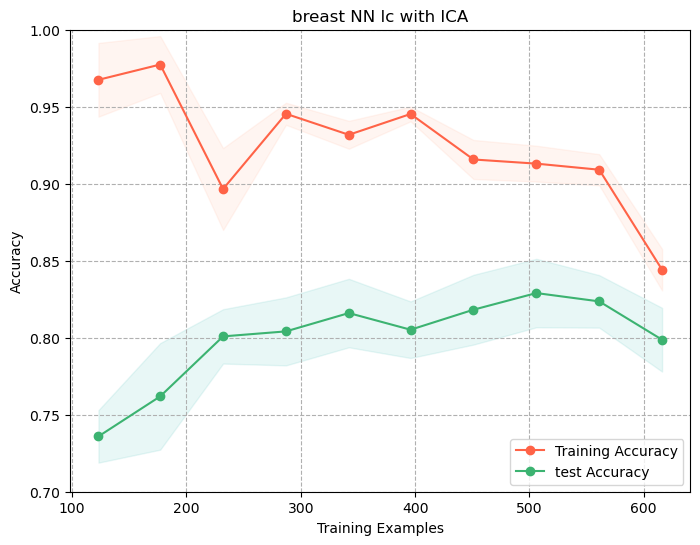

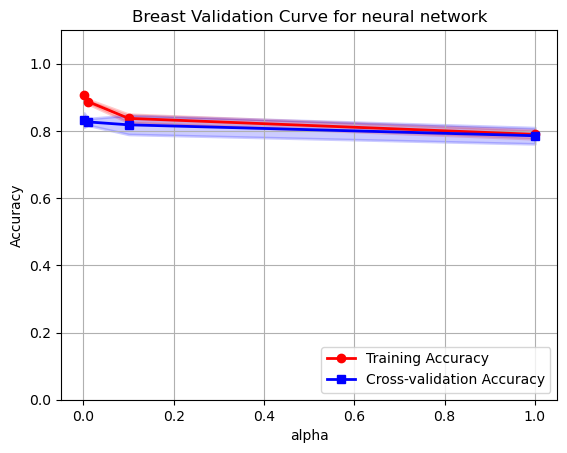

In [81]:
ica = FastICA(n_components=components, random_state=42, max_iter=1000)
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

GSNN = GridSearchCV(MLPClassifier(max_iter=1000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
start_time = time.time()
GSNN.fit(X_train_ica, y_train)
pred_nn = GSNN.predict(X_test_ica)
elapsed_time = time.time() - start_time
print(elapsed_time)

plot_learning_curve(GSNN.best_estimator_, "breast NN lc with ICA", X_train_ica, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train_ica, y_train, GSNN.best_estimator_, "neural network")

In [38]:
import time as time
def nn_rp_classification_report_summary(X_train, X_test, y_train, y_test):
    rp_components = [2, 5, 7, 10, 13, 15]
    param_nn = {
        'alpha': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 2, 3],
        'learning_rate_init': [0.001, 0.01, 0.1, 1],
        'activation': ['tanh', 'relu']
    }
    n_thread = -1  # Use all available CPUs
    
    accuracy_scores_rp = []
    computation_times_rp = []
    f1_scores_label_1 = []
    f1_scores_label_2 = []
    for components in rp_components:
        rp = GaussianRandomProjection(n_components=components, random_state=42)
        X_train_rp = rp.fit_transform(X_train)
        X_test_rp = rp.transform(X_test)

        GSNN = GridSearchCV(MLPClassifier(max_iter=1000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
        start_time = time.time()
        GSNN.fit(X_train_rp, y_train)
        pred_nn = GSNN.predict(X_test_rp)
        elapsed_time = time.time() - start_time

        accuracy = accuracy_score(y_test, pred_nn)
        f1 = f1_score(y_test, pred_nn, average=None)
        accuracy_scores_rp.append(accuracy)
        computation_times_rp.append(elapsed_time)
        f1_scores_label_1.append(f1[0])
        f1_scores_label_2.append(f1[1])
    
    print("accuracy: ", accuracy_scores_rp)
    print("f1-score for Class 0: ", f1_scores_label_1)
    print("f1-score for Class 1: ", f1_scores_label_2)
    print("Time consued: ", computation_times_rp)

nn_rp_classification_report_summary(X_train, X_test, y_train, y_test)

accuracy:  [0.788961038961039, 0.8311688311688312, 0.8181818181818182, 0.8474025974025974, 0.8311688311688312, 0.8376623376623377]
f1-score for Class 0:  [0.8238482384823849, 0.8514285714285715, 0.8352941176470587, 0.8653295128939829, 0.8522727272727273, 0.8571428571428571]
f1-score for Class 1:  [0.7368421052631579, 0.8045112781954886, 0.7971014492753624, 0.8239700374531835, 0.803030303030303, 0.8120300751879698]
Time consued:  [3.2890470027923584, 3.2969558238983154, 3.720477819442749, 3.384155035018921, 3.3903701305389404, 3.4834299087524414]


In [39]:
import time as time
def nn_tsne_classification_report_summary(X_train, X_test, y_train, y_test):
    tsne_components = [5,10,15,20,25,30,35,40,45,50]
    param_nn = {
        'alpha': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 2, 3],
        'learning_rate_init': [0.001, 0.01, 0.1, 1],
        'activation': ['tanh', 'relu']
    }
    n_thread = -1  # Use all available CPUs
    
    accuracy_scores_tsne = []
    computation_times_tsne = []
    f1_scores_label_1 = []
    f1_scores_label_2 = []
    for components in tsne_components:
        tsne = TSNE(n_components=2, perplexity=components, random_state=42)
        X_train_tsne = tsne.fit_transform(X_train)
        X_test_tsne = tsne.fit_transform(X_test)

        GSNN = GridSearchCV(MLPClassifier(max_iter=1000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
        start_time = time.time()
        GSNN.fit(X_train_tsne, y_train)
        pred_nn = GSNN.predict(X_test_tsne)
        elapsed_time = time.time() - start_time

        accuracy = accuracy_score(y_test, pred_nn)
        f1 = f1_score(y_test, pred_nn, average=None)
        accuracy_scores_tsne.append(accuracy)
        computation_times_tsne.append(elapsed_time)
        f1_scores_label_1.append(f1[0])
        f1_scores_label_2.append(f1[1])
    
    print("accuracy: ", accuracy_scores_tsne)
    print("f1-score for Class 0: ", f1_scores_label_1)
    print("f1-score for Class 1: ", f1_scores_label_2)
    print("Time consued: ", computation_times_tsne)

nn_tsne_classification_report_summary(X_train, X_test, y_train, y_test)

accuracy:  [0.6233766233766234, 0.7857142857142857, 0.7857142857142857, 0.75, 0.5292207792207793, 0.512987012987013, 0.4383116883116883, 0.5584415584415584, 0.6266233766233766, 0.7272727272727273]
f1-score for Class 0:  [0.6547619047619047, 0.8166666666666667, 0.8216216216216216, 0.8030690537084398, 0.6472019464720196, 0.5398773006134969, 0.5620253164556962, 0.6304347826086956, 0.7012987012987014, 0.7868020304568528]
f1-score for Class 1:  [0.5857142857142857, 0.7421875000000001, 0.7317073170731707, 0.6577777777777778, 0.2926829268292683, 0.48275862068965514, 0.21719457013574658, 0.4516129032258065, 0.5021645021645021, 0.6216216216216216]
Time consued:  [3.928557872772217, 3.160275936126709, 3.8122570514678955, 3.466480016708374, 3.3373560905456543, 4.142638921737671, 4.058146715164185, 4.147733926773071, 3.7860429286956787, 4.499878883361816]


3.6536319255828857


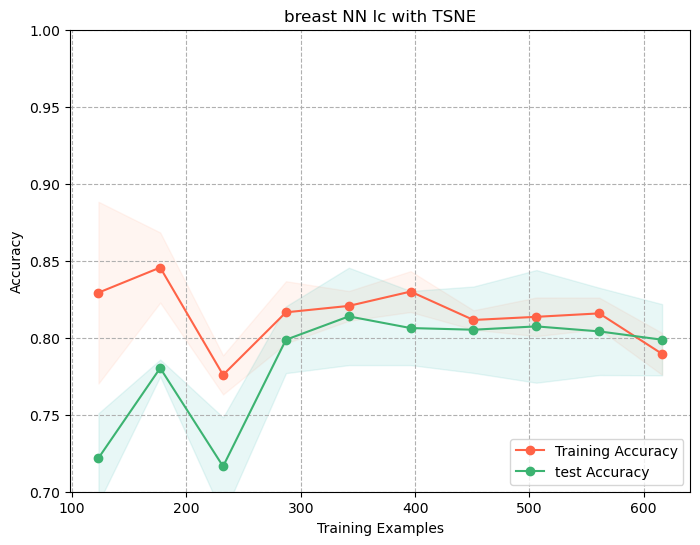

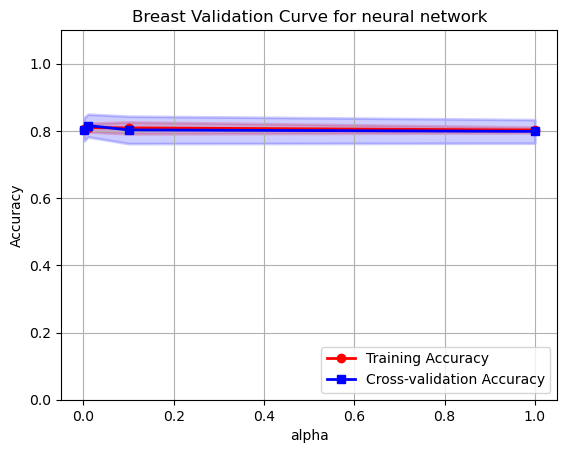

In [84]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

GSNN = GridSearchCV(MLPClassifier(max_iter=1000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
start_time = time.time()
GSNN.fit(X_train_tsne, y_train)
pred_nn = GSNN.predict(X_test_tsne)
elapsed_time = time.time() - start_time
print(elapsed_time)

plot_learning_curve(GSNN.best_estimator_, "breast NN lc with TSNE", X_train_tsne, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train_tsne, y_train, GSNN.best_estimator_, "neural network")

## Cluster Result in input features for KMeans

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.8376623376623377
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       159
           1       0.90      0.75      0.82       149

    accuracy                           0.84       308
   macro avg       0.85      0.83      0.84       308
weighted avg       0.85      0.84      0.84       308



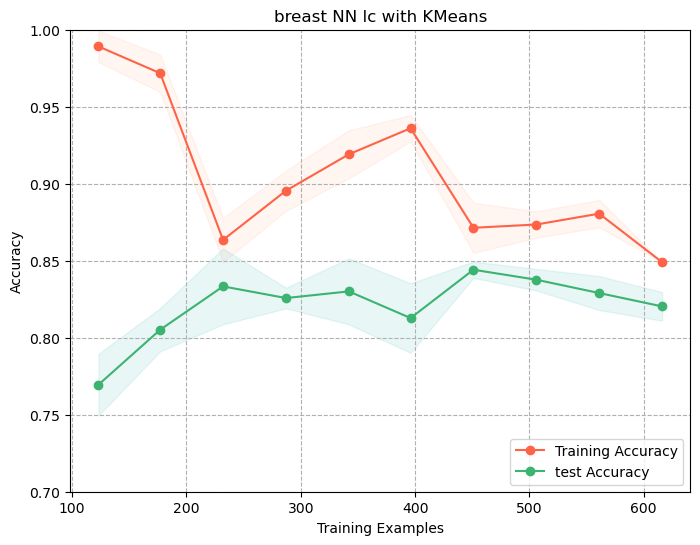

<module 'matplotlib.pyplot' from '/Users/davis901/anaconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [107]:
import time
param_nn = {
        'alpha': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 2, 3],
        'learning_rate_init': [0.001, 0.01, 0.1, 1],
        'activation': ['tanh', 'relu']
    }
# Step 1: Perform K-means clustering
n_clusters = 2  # Example, adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

# Step 2: Add cluster assignments as features
X_train_with_clusters = np.hstack((X_train, kmeans.labels_.reshape(-1, 1)))
X_test_with_clusters = np.hstack((X_test, kmeans.predict(X_test).reshape(-1, 1)))

# Step 3: Train MLPClassifier with the augmented data
mlp = GridSearchCV(MLPClassifier(max_iter=3000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
start = time.time()
mlp.fit(X_train_with_clusters, y_train)

# Step 4: Evaluate the model
predictions = mlp.predict(X_test_with_clusters)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

plot_learning_curve(mlp.best_estimator_, "breast NN lc with KMeans", X_train_with_clusters, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))


## Cluster Result in input features for EM

Training and evaluation took 7.34 seconds.
Accuracy: 0.8409090909090909
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       159
           1       0.90      0.75      0.82       149

    accuracy                           0.84       308
   macro avg       0.85      0.84      0.84       308
weighted avg       0.85      0.84      0.84       308



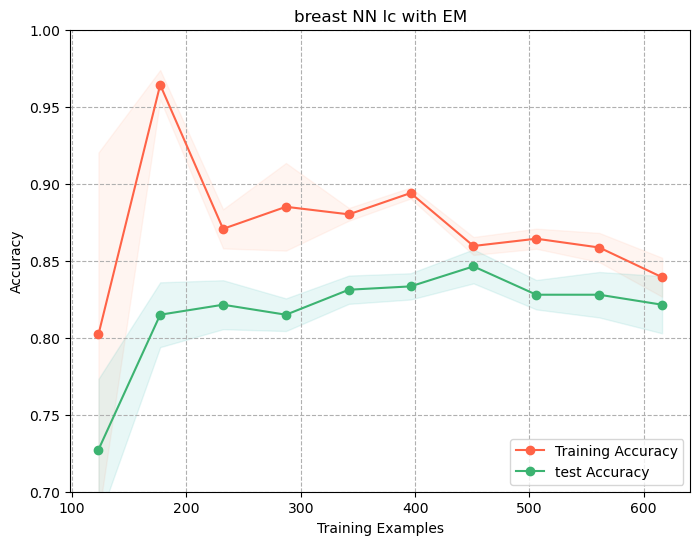

<module 'matplotlib.pyplot' from '/Users/davis901/anaconda3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [100]:
param_nn = {
    'alpha': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 2, 3],
    'learning_rate_init': [0.001, 0.01, 0.1, 1],
    'activation': ['tanh', 'relu']
}

n_thread = -1  # Assuming n_thread is defined; use -1 to utilize all processors

# Step 1: Perform Gaussian Mixture modeling for Expectation Maximization
n_clusters = 2  #  5 or 13
em = GaussianMixture(n_components=n_clusters, random_state=42)
em.fit(X_train)

# Use the predict method for hard assignment
train_cluster_assignments = em.predict(X_train)
test_cluster_assignments = em.predict(X_test)

# Step 2: Augment datasets with cluster assignments
X_train_with_clusters = np.hstack((X_train, train_cluster_assignments.reshape(-1, 1)))
X_test_with_clusters = np.hstack((X_test, test_cluster_assignments.reshape(-1, 1)))

# Step 3: Train MLPClassifier with the augmented data
mlp = GridSearchCV(MLPClassifier(max_iter=2000), param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
start_time = time.time()
mlp.fit(X_train_with_clusters, y_train)

# Step 4: Evaluate the model
predictions = mlp.predict(X_test_with_clusters)
print(f"Training and evaluation took {time.time() - start_time:.2f} seconds.")
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
plot_learning_curve(mlp.best_estimator_, "breast NN lc with EM", X_train_with_clusters, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
